## Reproduce Analysis for Task 3 corresponding to Figure 4 in the paper.

This notebook contains code and analysis for reproducing results for Figure 4

In [1]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from pathlib import Path
from functools import partial
import seaborn as sns

from lifelines.utils import concordance_index
import scipy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        colorway=px.colors.qualitative.D3,
    )
)

from utils import plot_km_curve, get_univariate_result, get_model_stats, get_model_comparison_stats

### Load CSV files for each of the implementation approach predictions

We load saved prediction files for each of the implementation approaches for the LUNG1 and RADIO datasets. The CSVs contain the predicted probabilities 2-year overall survival. 

In [2]:
path = Path("../outputs/predictions/task3")

In [3]:
lung1_implementation_dict = {
    "Foundation (Features)": path / "LUNG1" / "foundation_features.csv",
    "Foundation (Finetuned)": path / "LUNG1" / "foundation_finetuned.csv",
    "Supervised": path / "LUNG1" / "supervised.csv",
    "Supervised (Finetuned)": path / "LUNG1" / "supervised_finetuned.csv",
    "Med3D (Features)": path / "LUNG1" / "med3d_features.csv",
    "Med3D (Finetuned)": path / "LUNG1" / "med3d_finetuned.csv",
    "Models Genesis (Features)": path / "LUNG1" / "modelsgen_features.csv",
    "Models Genesis (Finetuned)": path / "LUNG1" / "modelsgen_finetuned.csv",
}


radio_implementation_dict = {
    "Foundation (Features)": path / "RADIO" / "foundation_features.csv",
    "Foundation (Finetuned)": path / "RADIO" / "foundation_finetuned.csv",
    "Supervised": path / "RADIO" / "supervised.csv",
    "Supervised (Finetuned)": path / "RADIO" / "supervised_finetuned.csv",
    "Med3D (Features)": path / "RADIO" / "med3d_features.csv",
    "Med3D (Finetuned)": path / "RADIO" / "med3d_finetuned.csv",
    "Models Genesis (Features)": path / "RADIO" / "modelsgen_features.csv",
    "Models Genesis (Finetuned)": path / "RADIO" / "modelsgen_finetuned.csv",
}

harvardrt_implementation_dict = {
    "Foundation (Features)": path / "HarvardRT" / "foundation_features.csv",
    "Foundation (Finetuned)": path / "HarvardRT" / "foundation_finetuned.csv",
    "Supervised": path / "HarvardRT" / "supervised.csv",
    "Supervised (Finetuned)": path / "HarvardRT" / "supervised_finetuned.csv",
    "Med3D (Features)": path / "HarvardRT" / "med3d_features.csv",
    "Med3D (Finetuned)": path / "HarvardRT" / "med3d_finetuned.csv",
    "Models Genesis (Features)": path / "HarvardRT" / "modelsgen_features.csv",
    "Models Genesis (Finetuned)": path / "HarvardRT" / "modelsgen_finetuned.csv",
}


implementation_rank = {key: i for i, key in enumerate(radio_implementation_dict.keys())}

### Analysis for computing metrics for each of the implementation approaches

Here we compute the metrics for each of the implementation approaches along with the 95% confidence intervals. Each implementation approach is also compared to all other implementation 
approaches with a difference confidence interval and p-value. We bootstrap to compute the confidence intervals and run a permutation test for the p-values.

### LUNG1 Dataset

In [4]:
implementation_dict = lung1_implementation_dict
pbar = tqdm(total=len(implementation_dict))
results = []

# We use 1000 resamples in the study, but for the sake of time we use reproduce results with 10 here
N_RESAMPLES = 1000

for implementation_name, model_prediction_csv in implementation_dict.items():
    df = pd.read_csv(model_prediction_csv)
    lung1_annotations = pd.read_csv("../data/preprocessing/lung1/annotations.csv")
    lung1_annotations["surv2yr"] = (lung1_annotations["Survival.time"] / 365.0 >= 2).astype(int)
    lung1_annotations = lung1_annotations[
        ~((lung1_annotations["surv2yr"] == 0) & (lung1_annotations["deadstatus.event"].astype(int) == 0))
    ]
    df = df.merge(lung1_annotations, on="PatientID", how="inner")
    df.columns = df.columns.str.replace("_y", "")

    pred_set = (
        df["surv2yr"].values,
        df["conf_scores_class_1"].values if "conf_scores_class_1" in df.columns else df["conf_scores_class"].values,
    )

    auc_values = get_model_stats(
        *pred_set,
        fn="roc_auc_score",
        nsamples=N_RESAMPLES,
    )

    c_index = concordance_index(df["Survival.time"], pred_set[1])

    row = {
        "Implementation": implementation_name,
        "AUC": np.mean(auc_values),
        "Concordance": c_index,
        "AUC_low_CI": np.percentile(auc_values, 2.5),
        "AUC_high_CI": np.percentile(auc_values, 97.5),
        "AUC_values": auc_values,
        "random_pvalue": scipy.stats.mannwhitneyu(pred_set[1], 1 - pred_set[1]).pvalue,
    }

    # Compute statistics for comparison between this implementation and all other ones (difference CI and p-value)
    compare_impementations = {k: v for k, v in implementation_dict.items() if k != implementation_name}
    for _implementation_name, _model_prediction_csv in compare_impementations.items():
        _df = pd.read_csv(_model_prediction_csv)
        _df = _df.merge(lung1_annotations, on="PatientID", how="inner")
        _df.columns = _df.columns.str.replace("_y", "")
        _pred = _df["conf_scores_class_1"].values if "conf_scores_class_1" in _df.columns else _df["conf_scores_class"].values
        _pred_set = (*pred_set, _pred)

        perm_test = get_model_comparison_stats(
            *_pred_set,
            fn="roc_auc_score",
            nsamples=N_RESAMPLES,
        )

        row[f"AUC_diff_CI_low_{_implementation_name}"] = perm_test[0][0]
        row[f"AUC_diff_CI_high_{_implementation_name}"] = perm_test[0][1]
        row[f"AUC_pval_{_implementation_name}"] = perm_test[1]

    results.append(row)
    pbar.update(1)

100%|██████████| 8/8 [03:58<00:00, 29.48s/it]

In [ ]:
for implementation_name, model_prediction_csv in implementation_dict.items():
    df = pd.read_csv(model_prediction_csv)
    lung1_annotations = pd.read_csv("../data/preprocessing/lung1/annotations.csv")
    lung1_annotations["surv2yr"] = (lung1_annotations["Survival.time"] / 365.0 >= 2).astype(int)
    lung1_annotations = lung1_annotations[
        ~((lung1_annotations["surv2yr"] == 0) & (lung1_annotations["deadstatus.event"].astype(int) == 0))
    ]
    df = df.merge(lung1_annotations, on="PatientID", how="inner")
    df.columns = df.columns.str.replace("_y", "")

    pred_set = (
        df["surv2yr"].values,
        df["conf_scores_class_1"].values if "conf_scores_class_1" in df.columns else df["conf_scores_class"].values,
    )

    # Plotting the histogram of pred_set[1] values
    plt.hist(pred_set[1], bins=50, alpha=0.5)
    plt.title(f"Histogram of {implementation_name} Scores")
    plt.xlabel("Prediction Score")
    plt.ylabel("Frequency")
    plt.show()

In [5]:
results_df = pd.DataFrame(results)
results_df.to_pickle("lung1_results.pkl ")

In [14]:
results_df = pd.read_pickle("lung1_results.pkl ")
results_df["Implementation_Rank"] = results_df["Implementation"].map(implementation_rank)
results_df.sort_values(by=["Implementation_Rank"], inplace=True, ascending=True)
results_df.drop("Implementation_Rank", axis=1, inplace=True)

### Generate the figures
The figures are reproduced using plotly 

In [6]:
gray_palette = sns.color_palette("gray", 6).as_hex()

In [17]:
for metric in ["AUC"]:
    results_df[f"e_plus_{metric}"] = results_df[f"{metric}_high_CI"] - results_df[metric]
    results_df[f"e_minus_{metric}"] = results_df[metric] - results_df[f"{metric}_low_CI"]
    metric_values = results_df[f"{metric}_values"].values

    colors = ["#3182BD", "#00A3D5", *gray_palette]
    fig = px.bar(
        results_df,
        x="Implementation",
        y=metric,
        error_y=f"e_plus_{metric}",
        error_y_minus=f"e_minus_{metric}",
        color="Implementation",
        template="simple_white",
        labels={"Model": "", metric: metric, "Implementation": ""},
        color_discrete_sequence=colors,  # Use the blues color palette
        range_y=[0.3, 0.8],
    )

    random_val = np.random.rand(len(metric_values[0]))
    for sample_idx in range(len(metric_values[0])):
        fig.add_trace(
            go.Box(
                x=results_df["Implementation"],
                y=[metric_values[i][sample_idx] for i in range(len(metric_values))],
                marker=dict(color="black", symbol="circle", size=1, line=dict(width=0)),
                fillcolor="rgba(255, 255, 255,0)",
                line=dict(
                    width=0,
                ),
                boxpoints="all",  # display the original data points
                opacity=0.2,
                pointpos=-1.6 + (random_val[sample_idx] * 3.2),
                showlegend=False,
            )
        )

    title = "Full training set"
    fig.update_layout(
        title=title,
        width=600,
        height=500,
        bargap=0,
        autosize=True,
        legend=dict(
            orientation="v",
        ),
        template="simple_white",
        title_x=0.5,
        xaxis=dict(showticklabels=False),
        yaxis=dict(showgrid=True),
        xaxis_title=None,
        showlegend=True,
    ),
    for trace in fig.data:
        if isinstance(trace, go.Bar):
            trace.error_y.thickness = 1
    fig.show()

    fig.write_image(f"figures_vector_pdf/lung1_{metric}_dot.pdf")
    fig.data = []

In [15]:
median_dict = {}
for model_implementation, path in harvardrt_implementation_dict.items():
    val_df = pd.read_csv(path)
    median = np.median(val_df["conf_scores_class_1"].values)
    median_dict[model_implementation] = median

#### Kaplan Meier Curves for Foundation

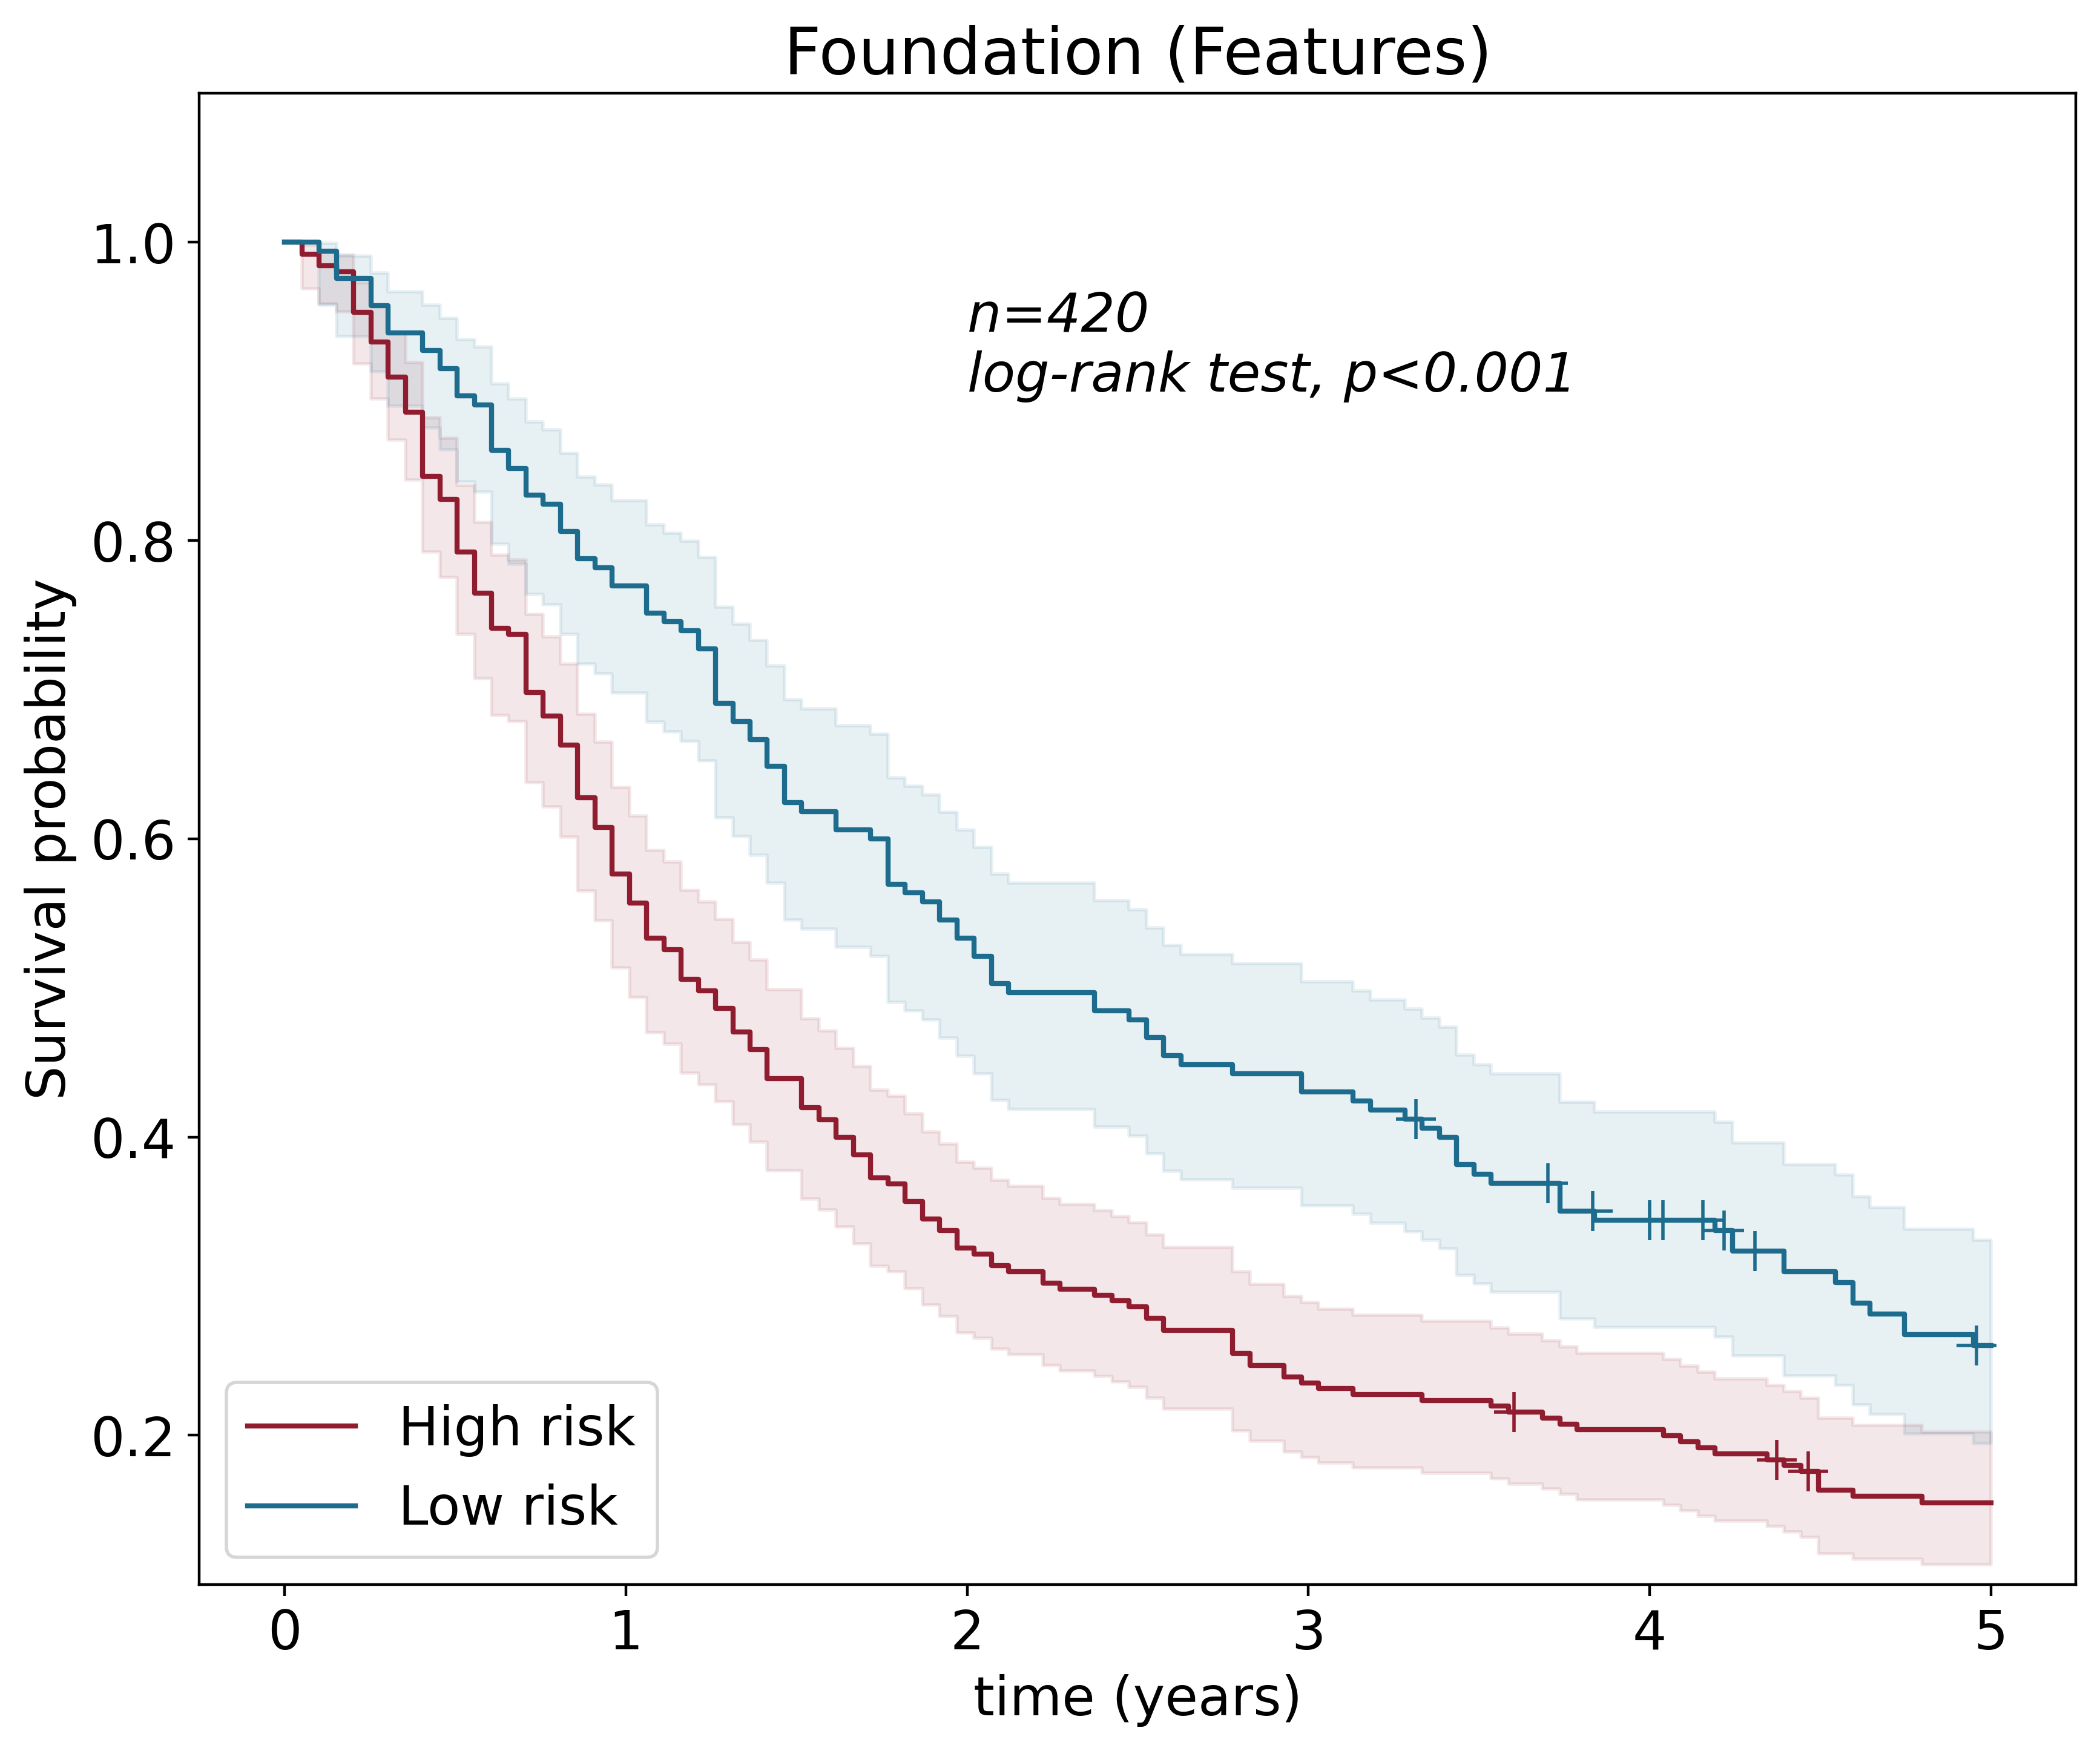

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1963.27
         time fit was run = 2024-01-18 01:14:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.36       1.43       0.11             0.15             0.57                 1.16                 1.76

            cmp to    z      p   -log2(p)
covariate                                
group         0.00 3.32 <0.005      10.13
---
Concordance = 0.56
Partial AIC = 3928.54
log-likelihood ratio test = 11.30 on 1 df
-log2(p) of ll-ratio test = 10.33

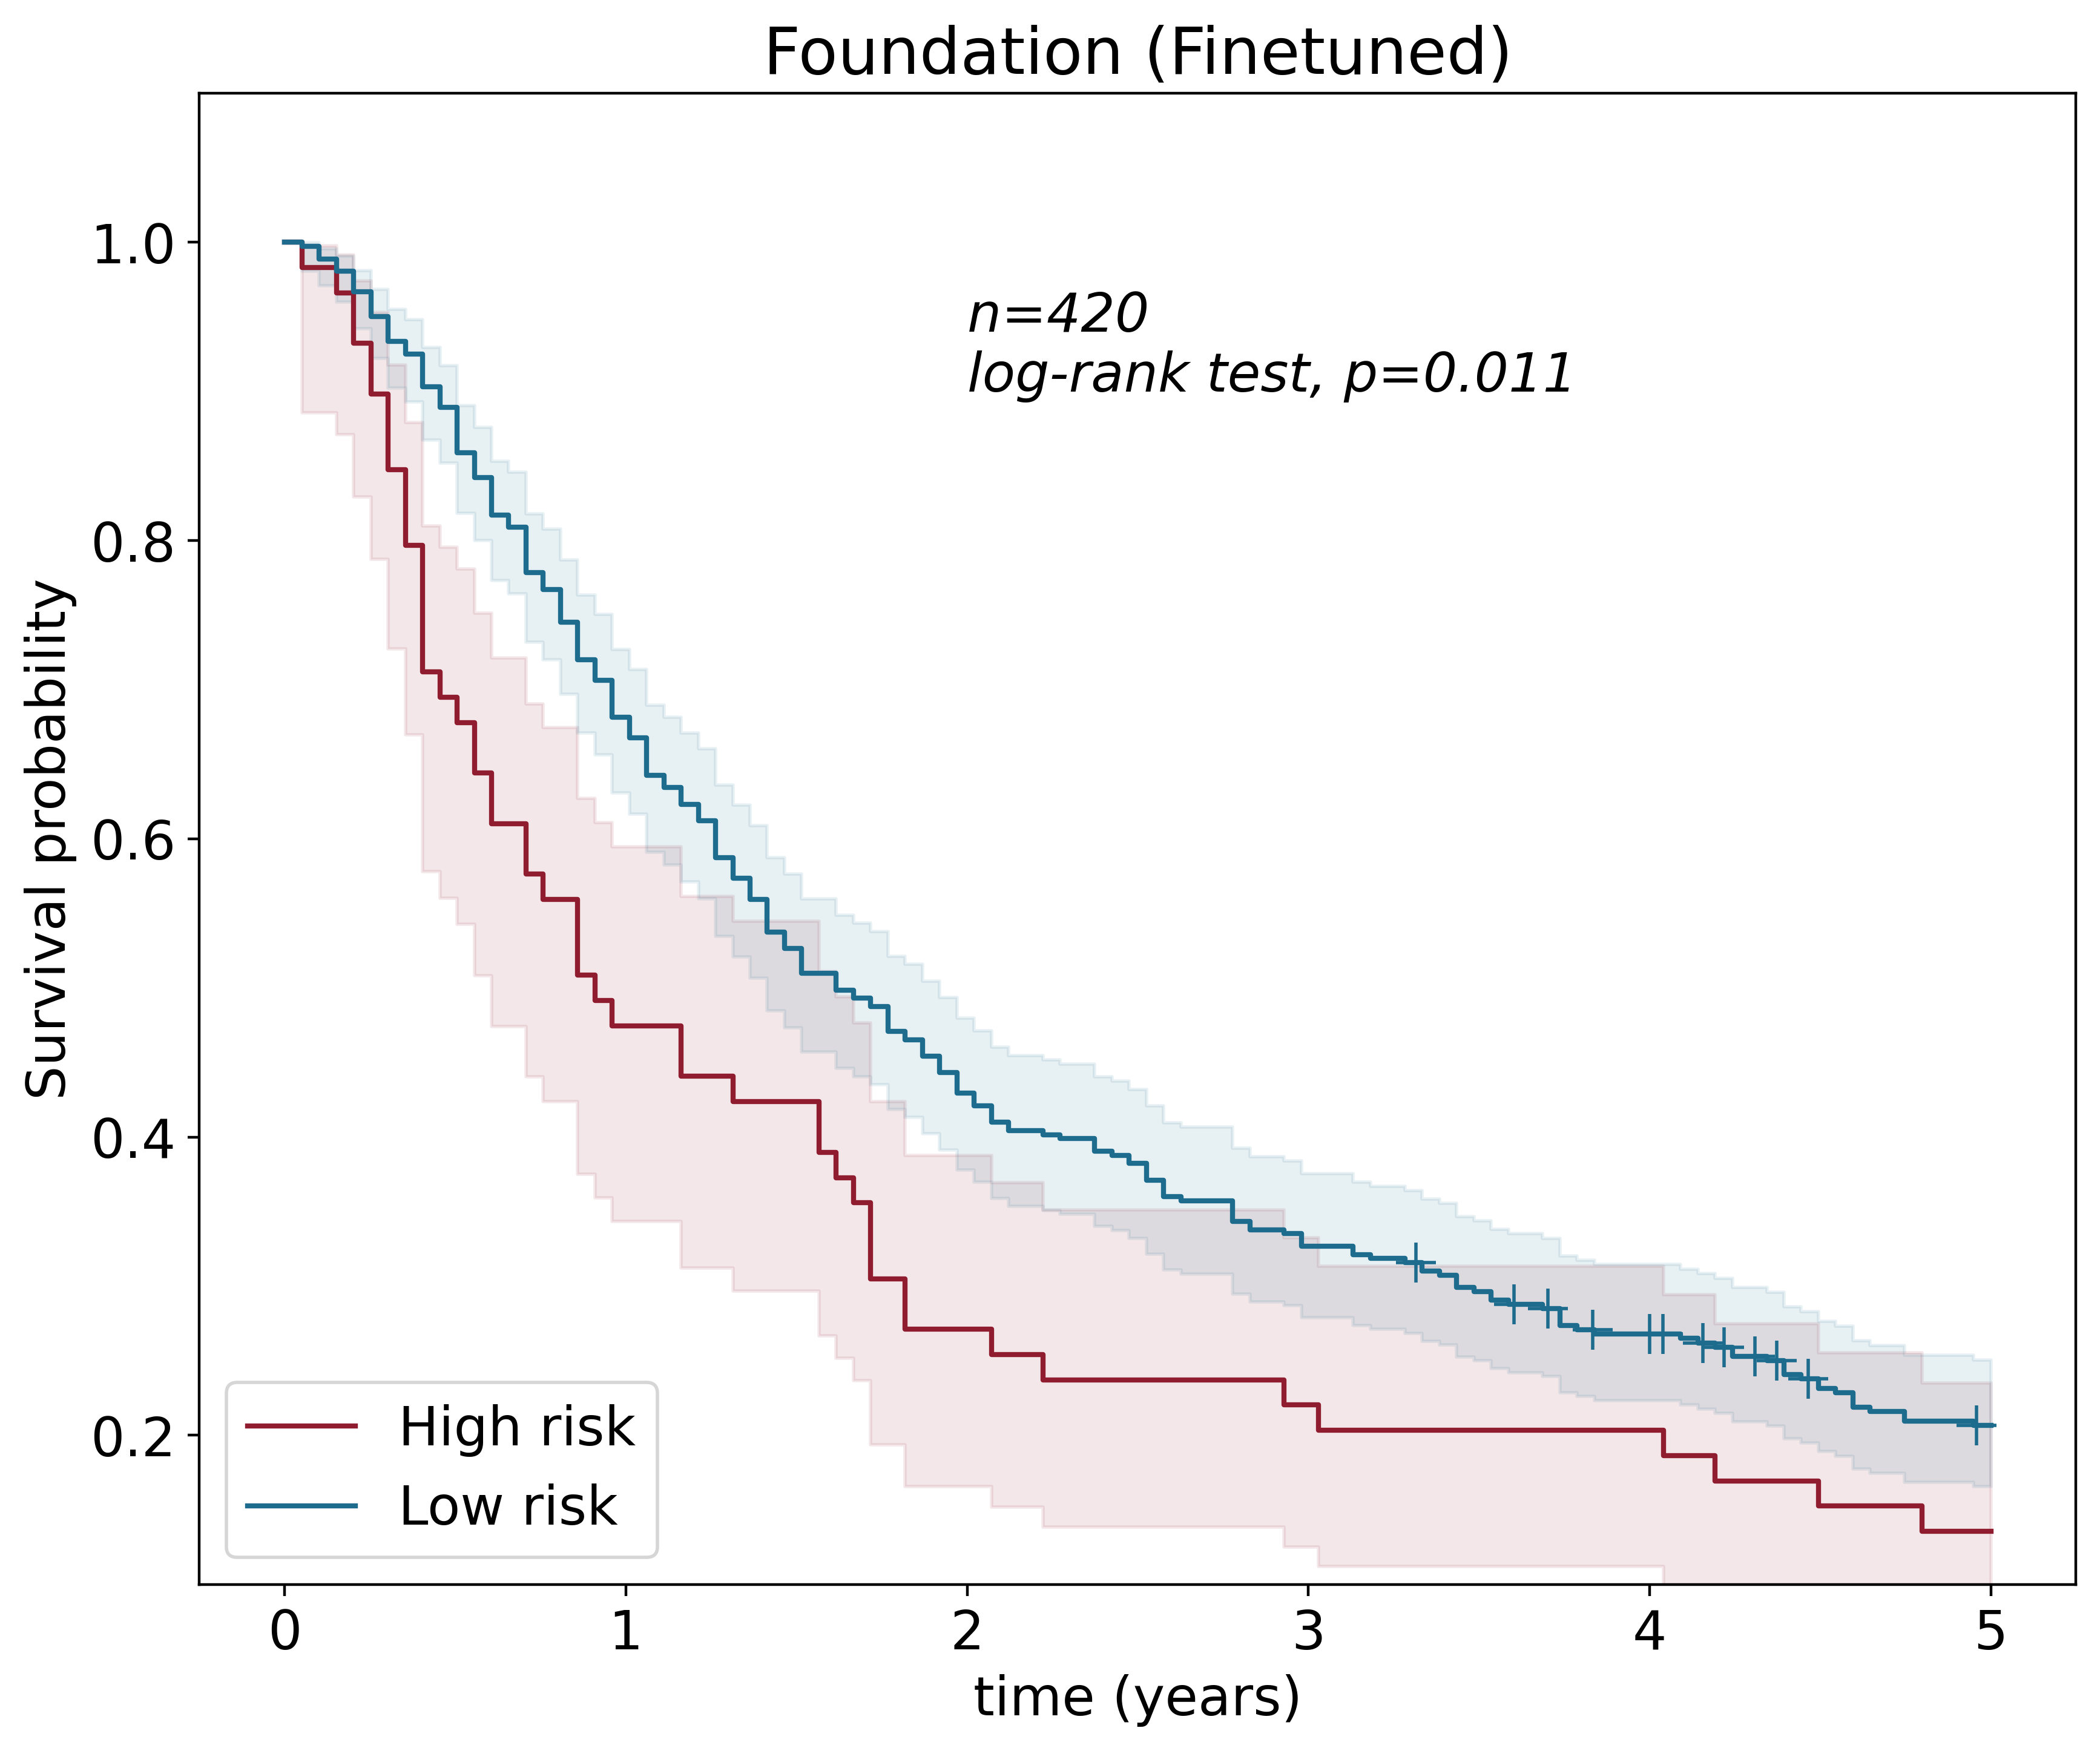

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1966.50
         time fit was run = 2024-01-18 01:14:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.33       1.40       0.15             0.05             0.62                 1.05                 1.86

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 2.29 0.02       5.49
---
Concordance = 0.53
Partial AIC = 3935.01
log-likelihood ratio test = 4.83 on 1 df
-log2(p) of ll-ratio test = 5.16

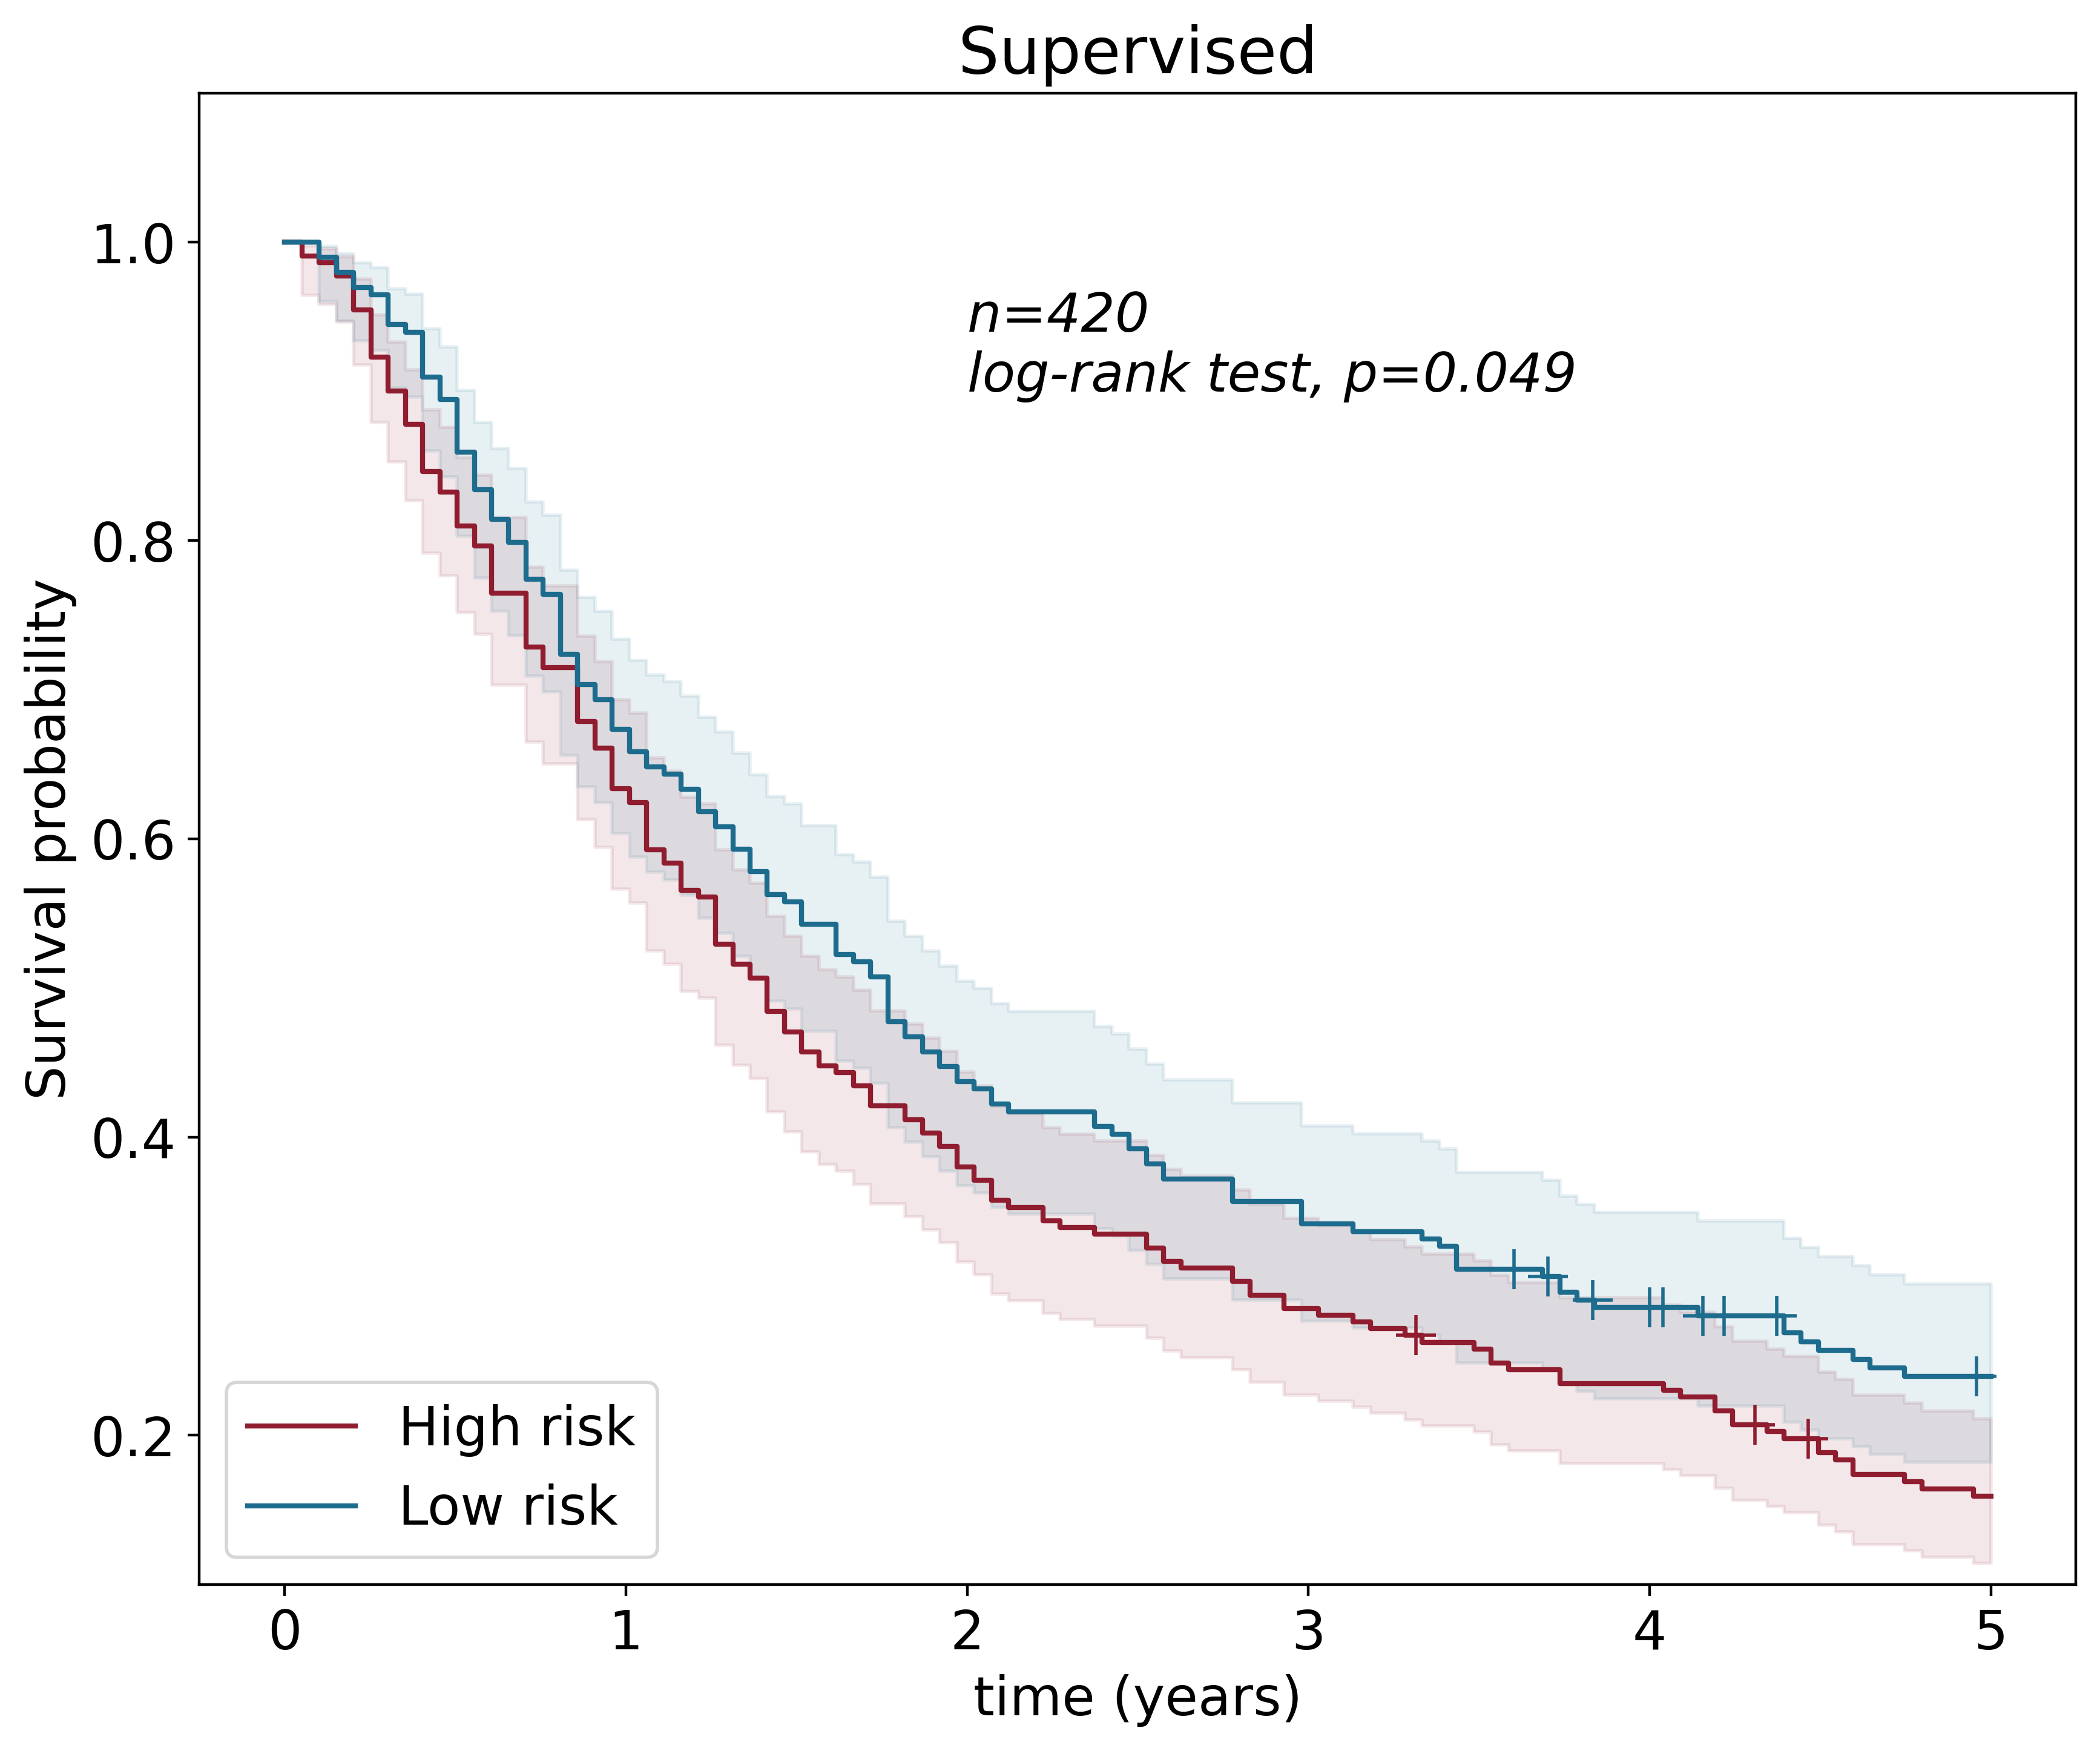

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1967.67
         time fit was run = 2024-01-18 01:14:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.16       1.18       0.10            -0.04             0.37                 0.96                 1.44

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.58 0.11       3.12
---
Concordance = 0.53
Partial AIC = 3937.34
log-likelihood ratio test = 2.49 on 1 df
-log2(p) of ll-ratio test = 3.13

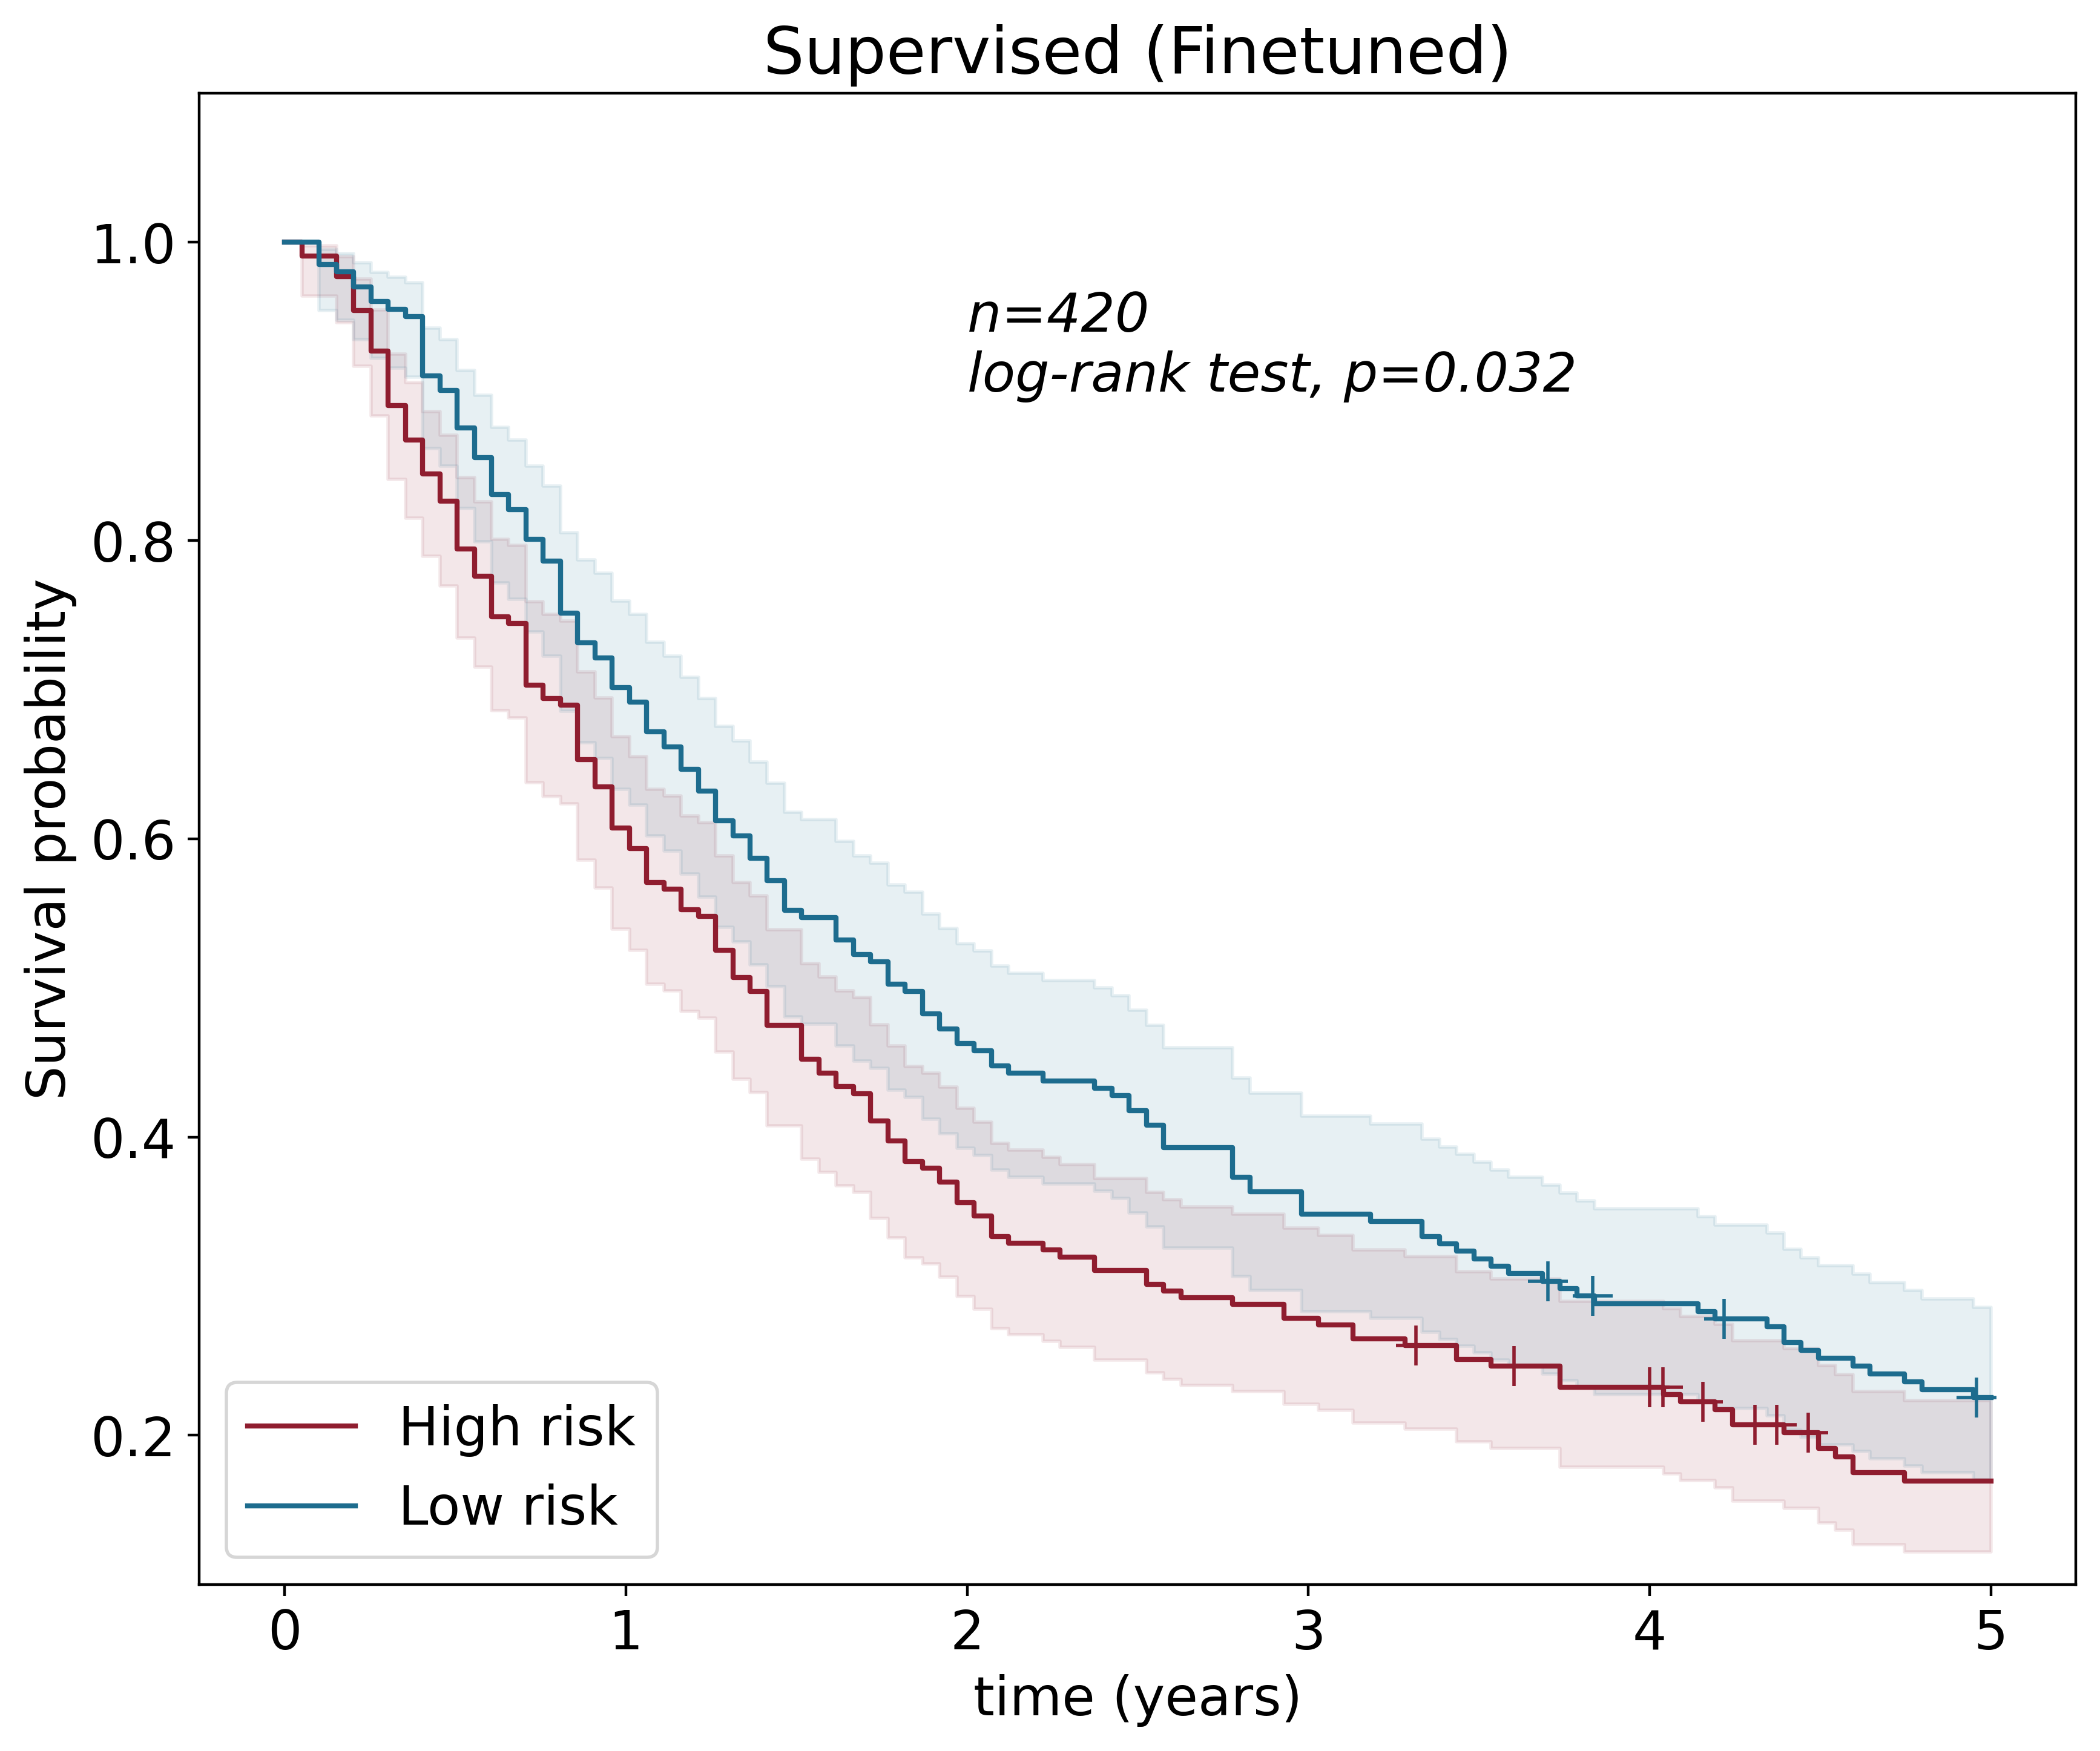

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1967.89
         time fit was run = 2024-01-18 01:14:26 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.15       1.16       0.10            -0.06             0.35                 0.95                 1.42

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.43 0.15       2.71
---
Concordance = 0.53
Partial AIC = 3937.79
log-likelihood ratio test = 2.04 on 1 df
-log2(p) of ll-ratio test = 2.71

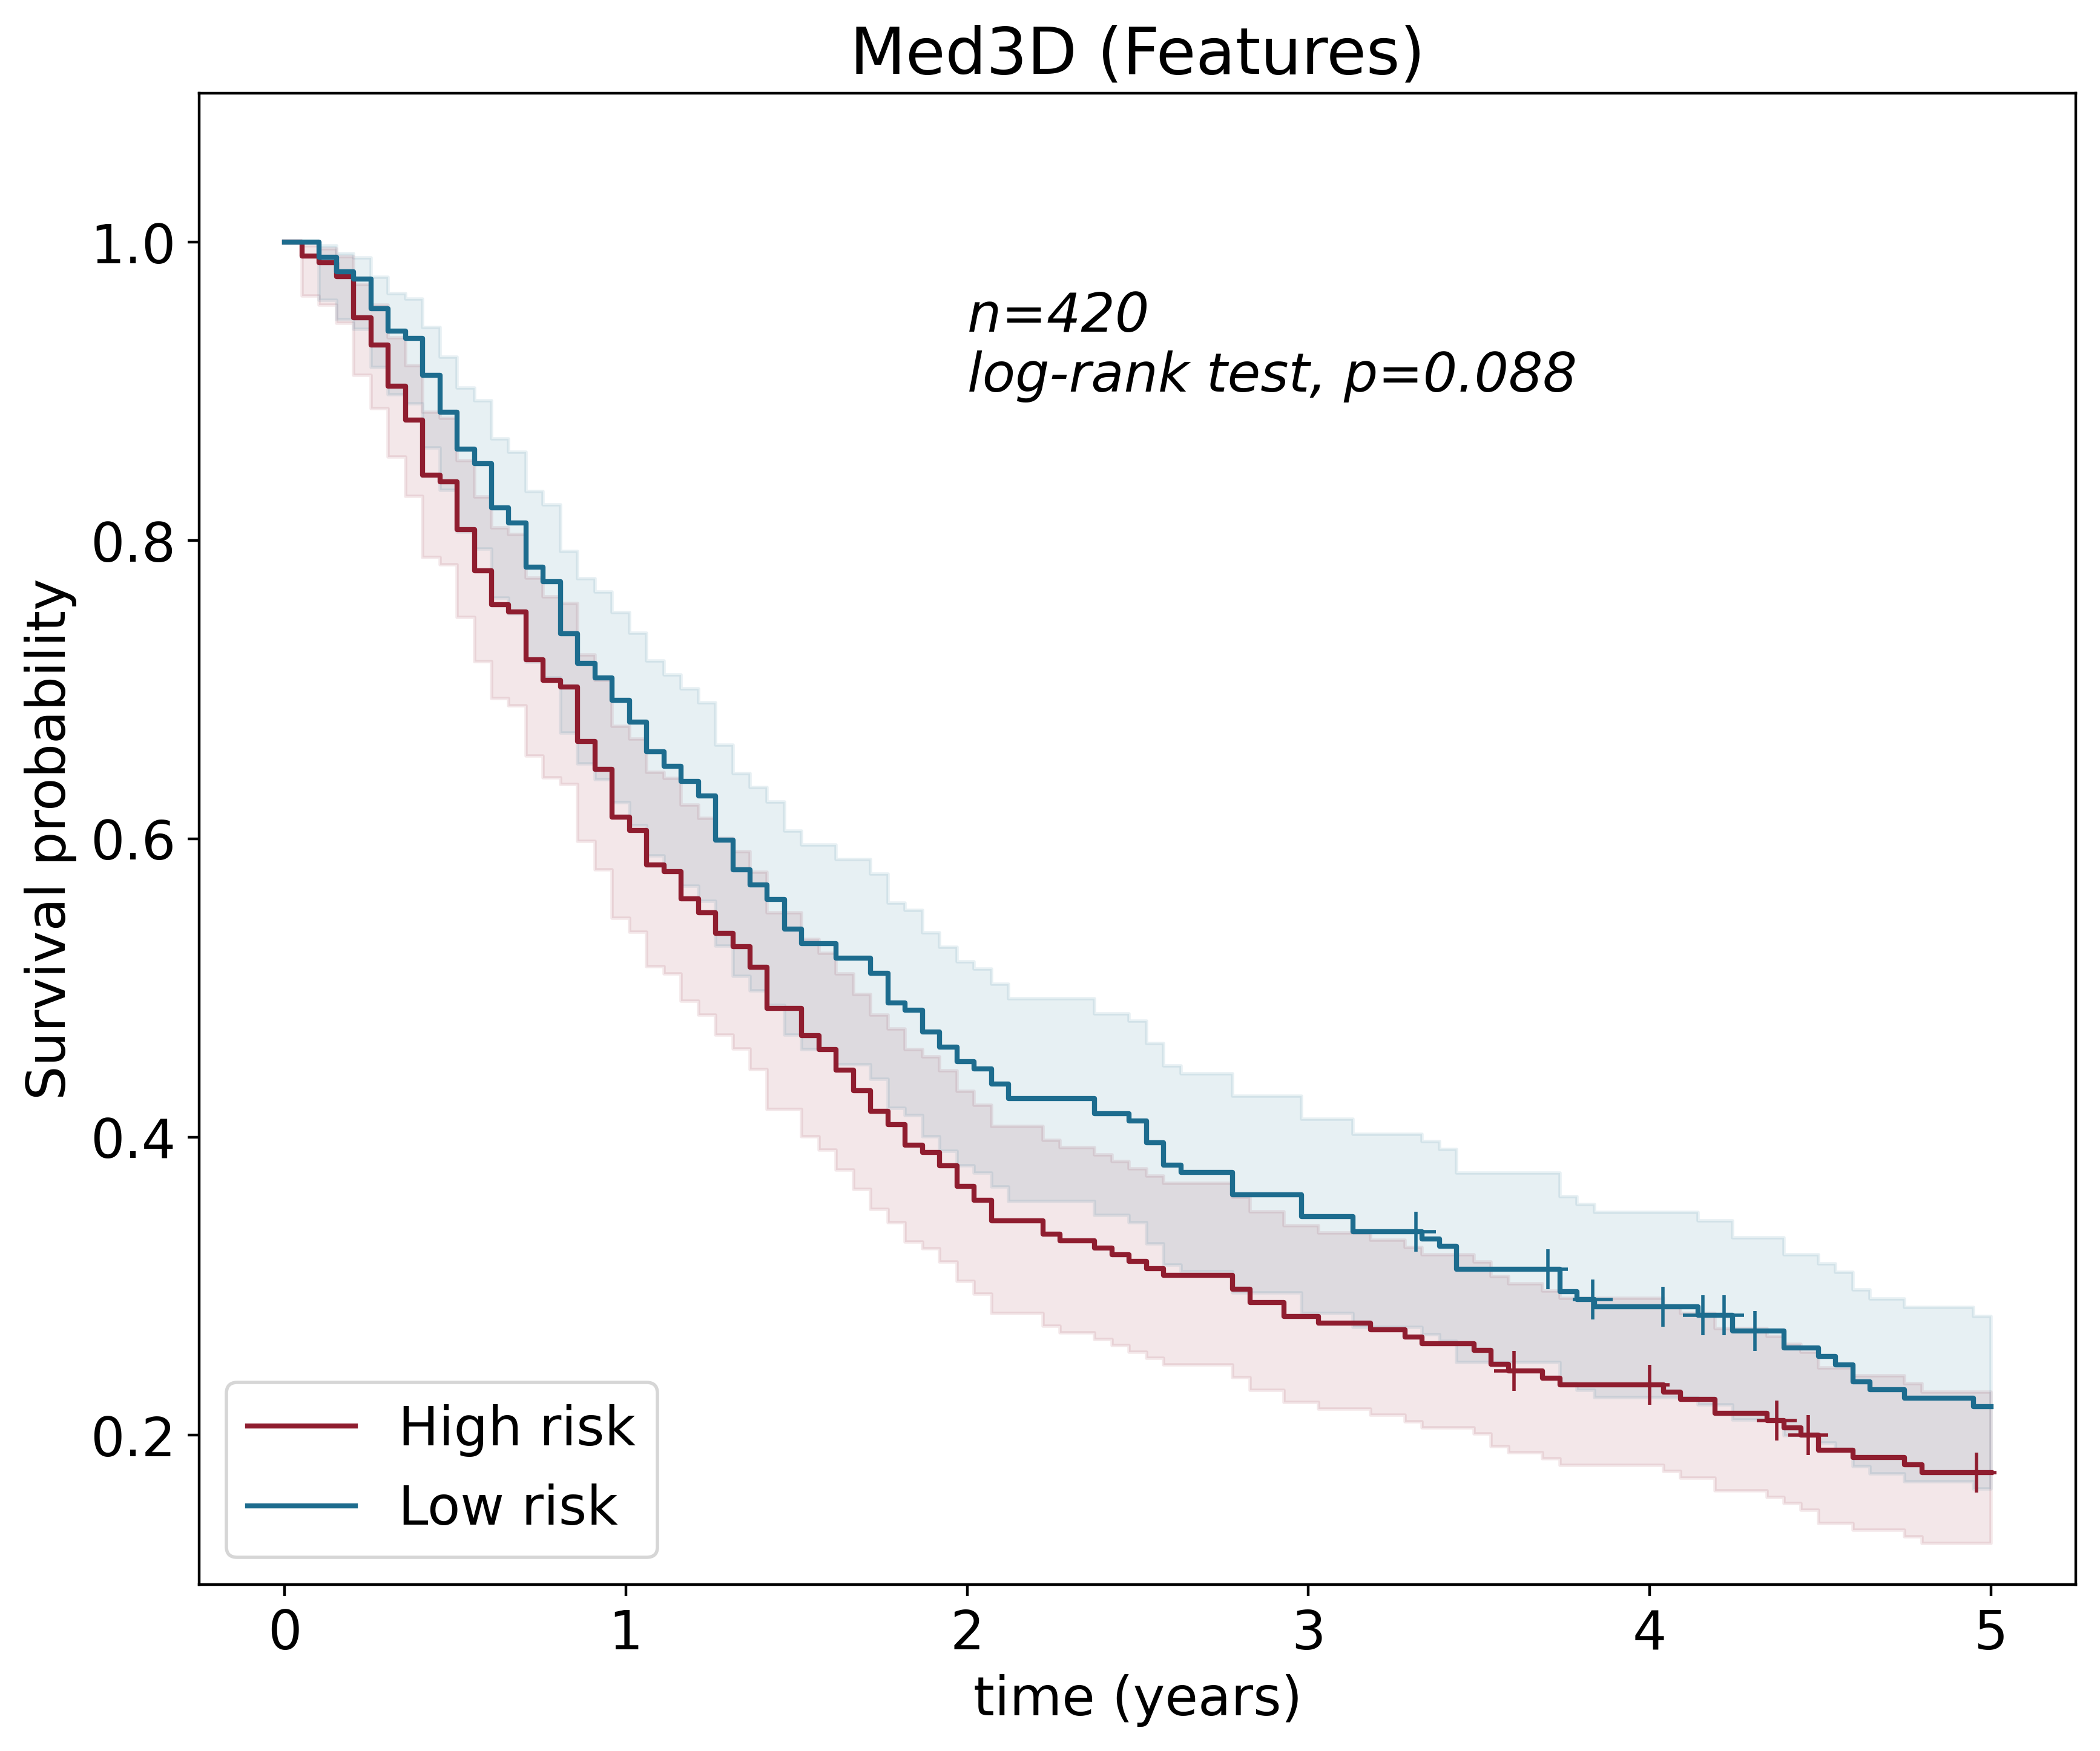

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1968.08
         time fit was run = 2024-01-18 01:14:28 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.13       1.14       0.10            -0.07             0.34                 0.93                 1.40

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.29 0.20       2.36
---
Concordance = 0.53
Partial AIC = 3938.16
log-likelihood ratio test = 1.68 on 1 df
-log2(p) of ll-ratio test = 2.36

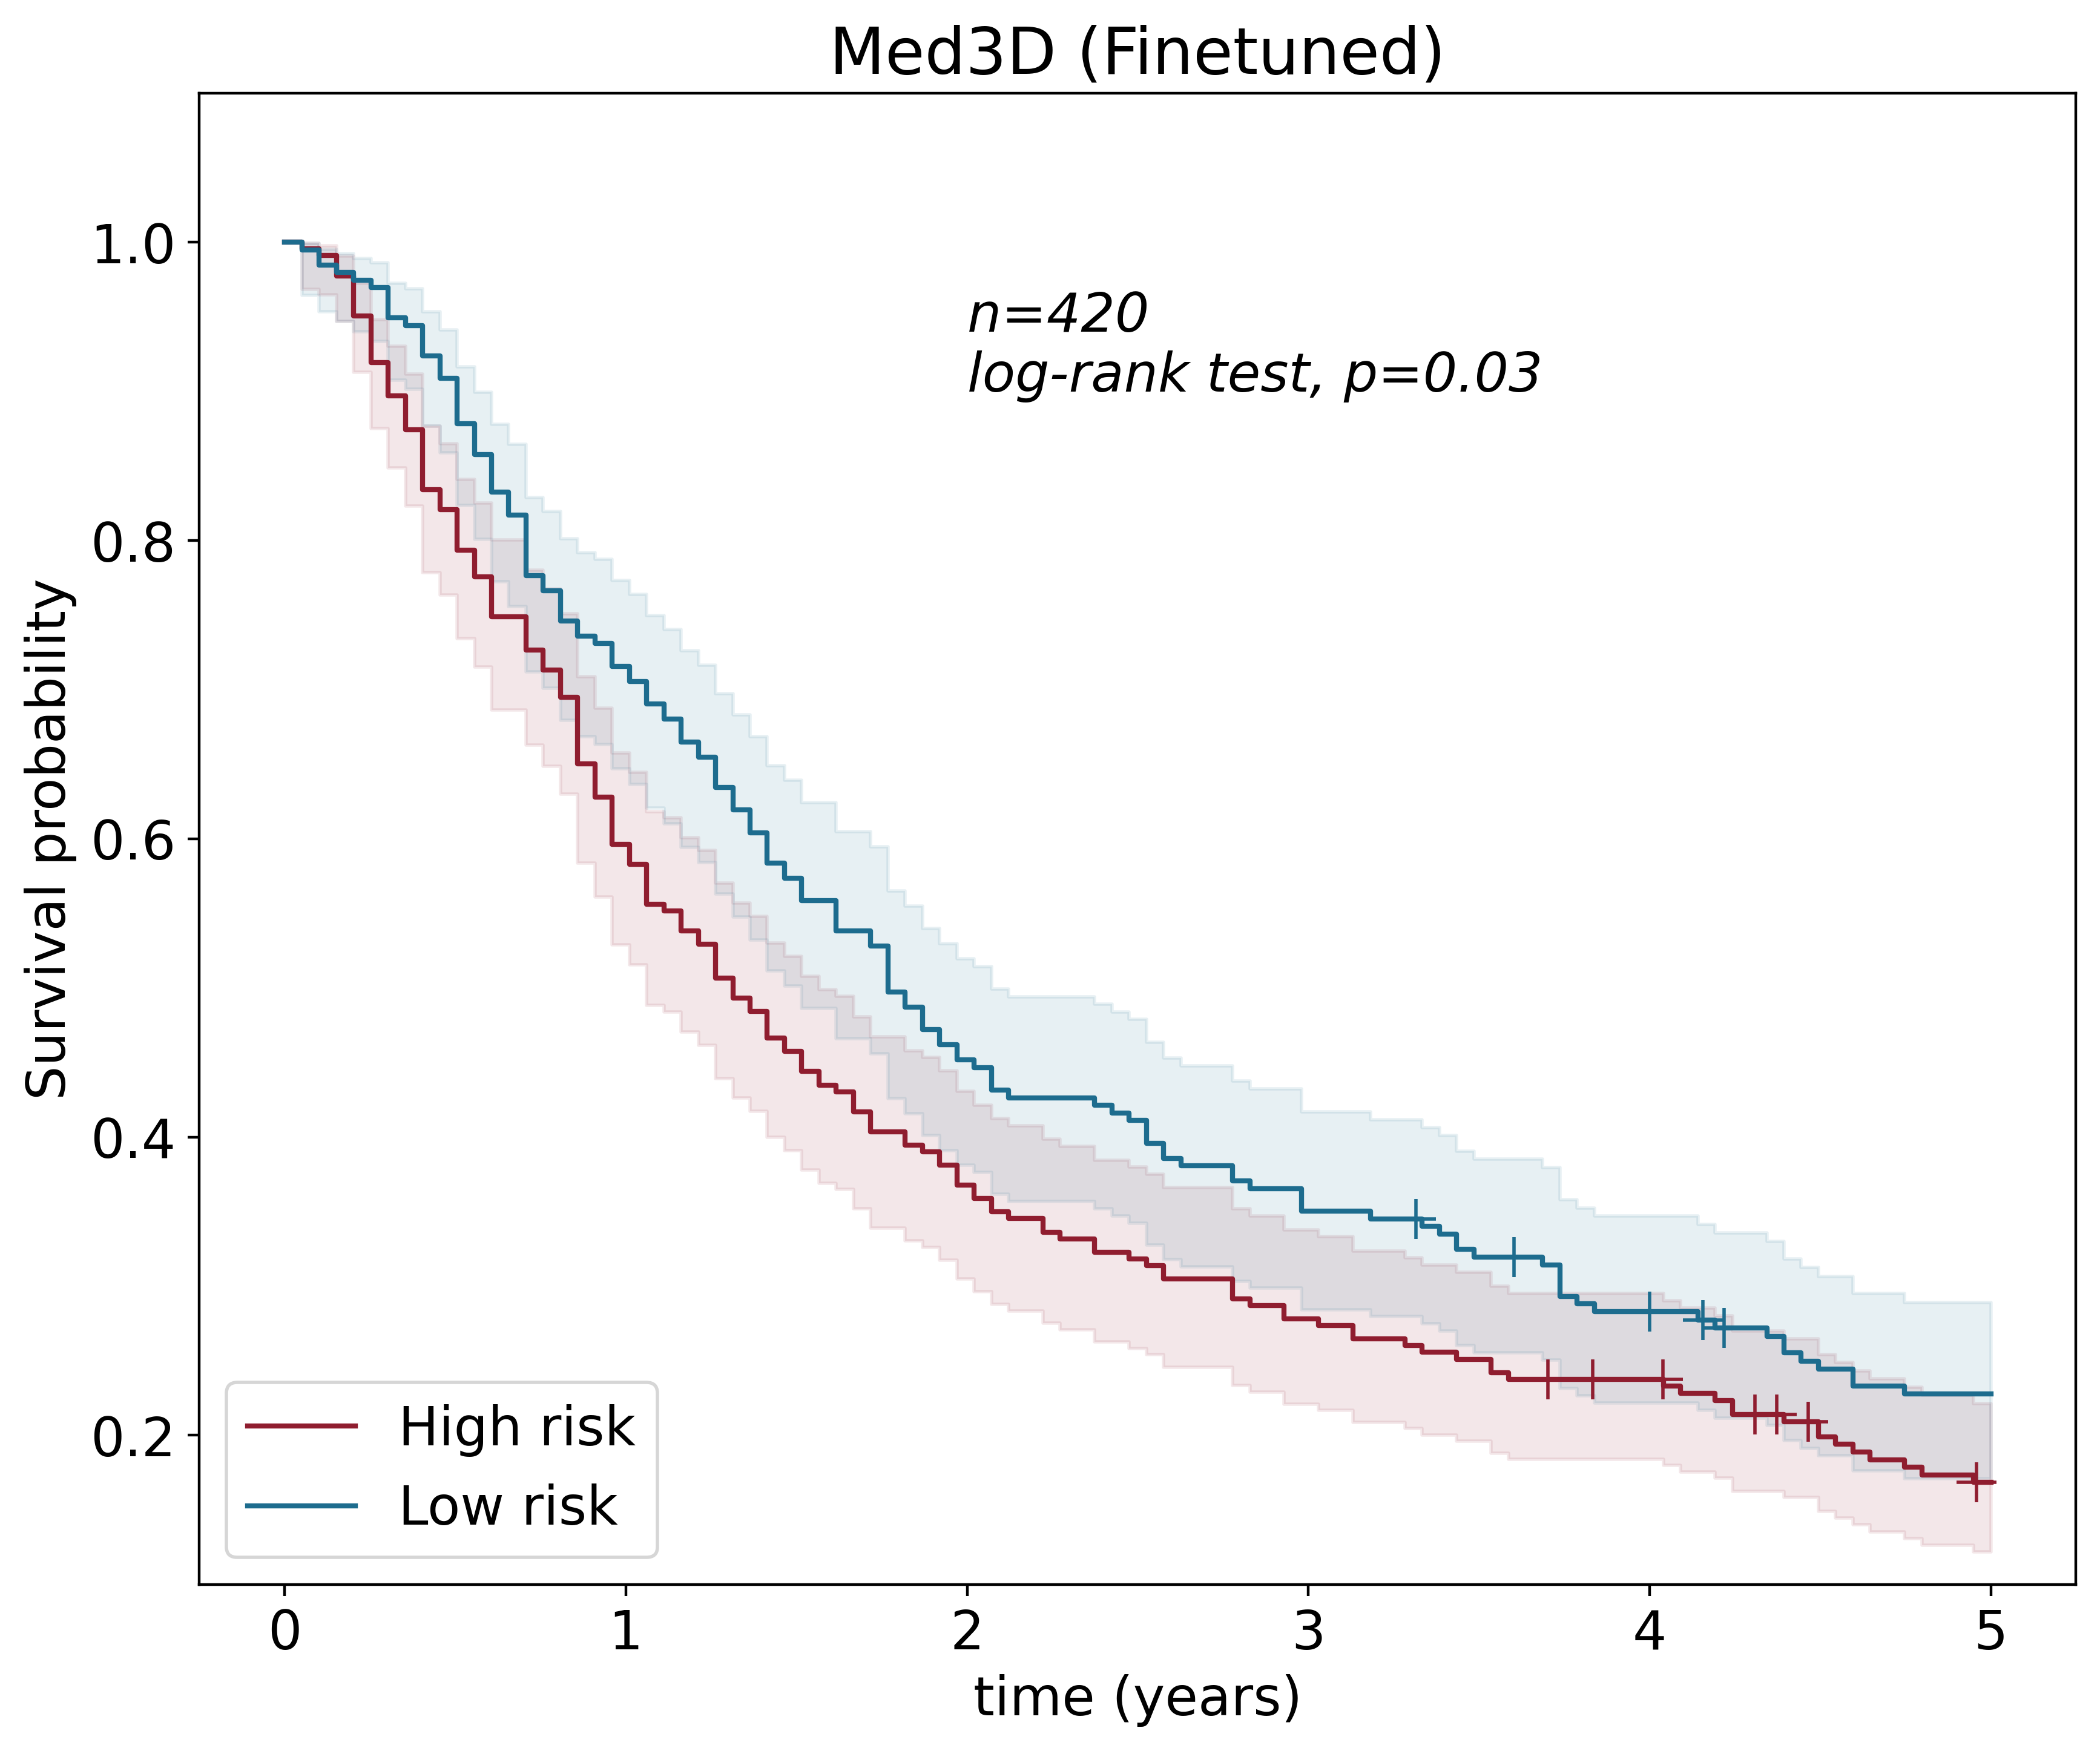

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1966.64
         time fit was run = 2024-01-18 01:14:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.22       1.25       0.10             0.02             0.43                 1.02                 1.53

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 2.13 0.03       4.91
---
Concordance = 0.54
Partial AIC = 3935.28
log-likelihood ratio test = 4.55 on 1 df
-log2(p) of ll-ratio test = 4.92

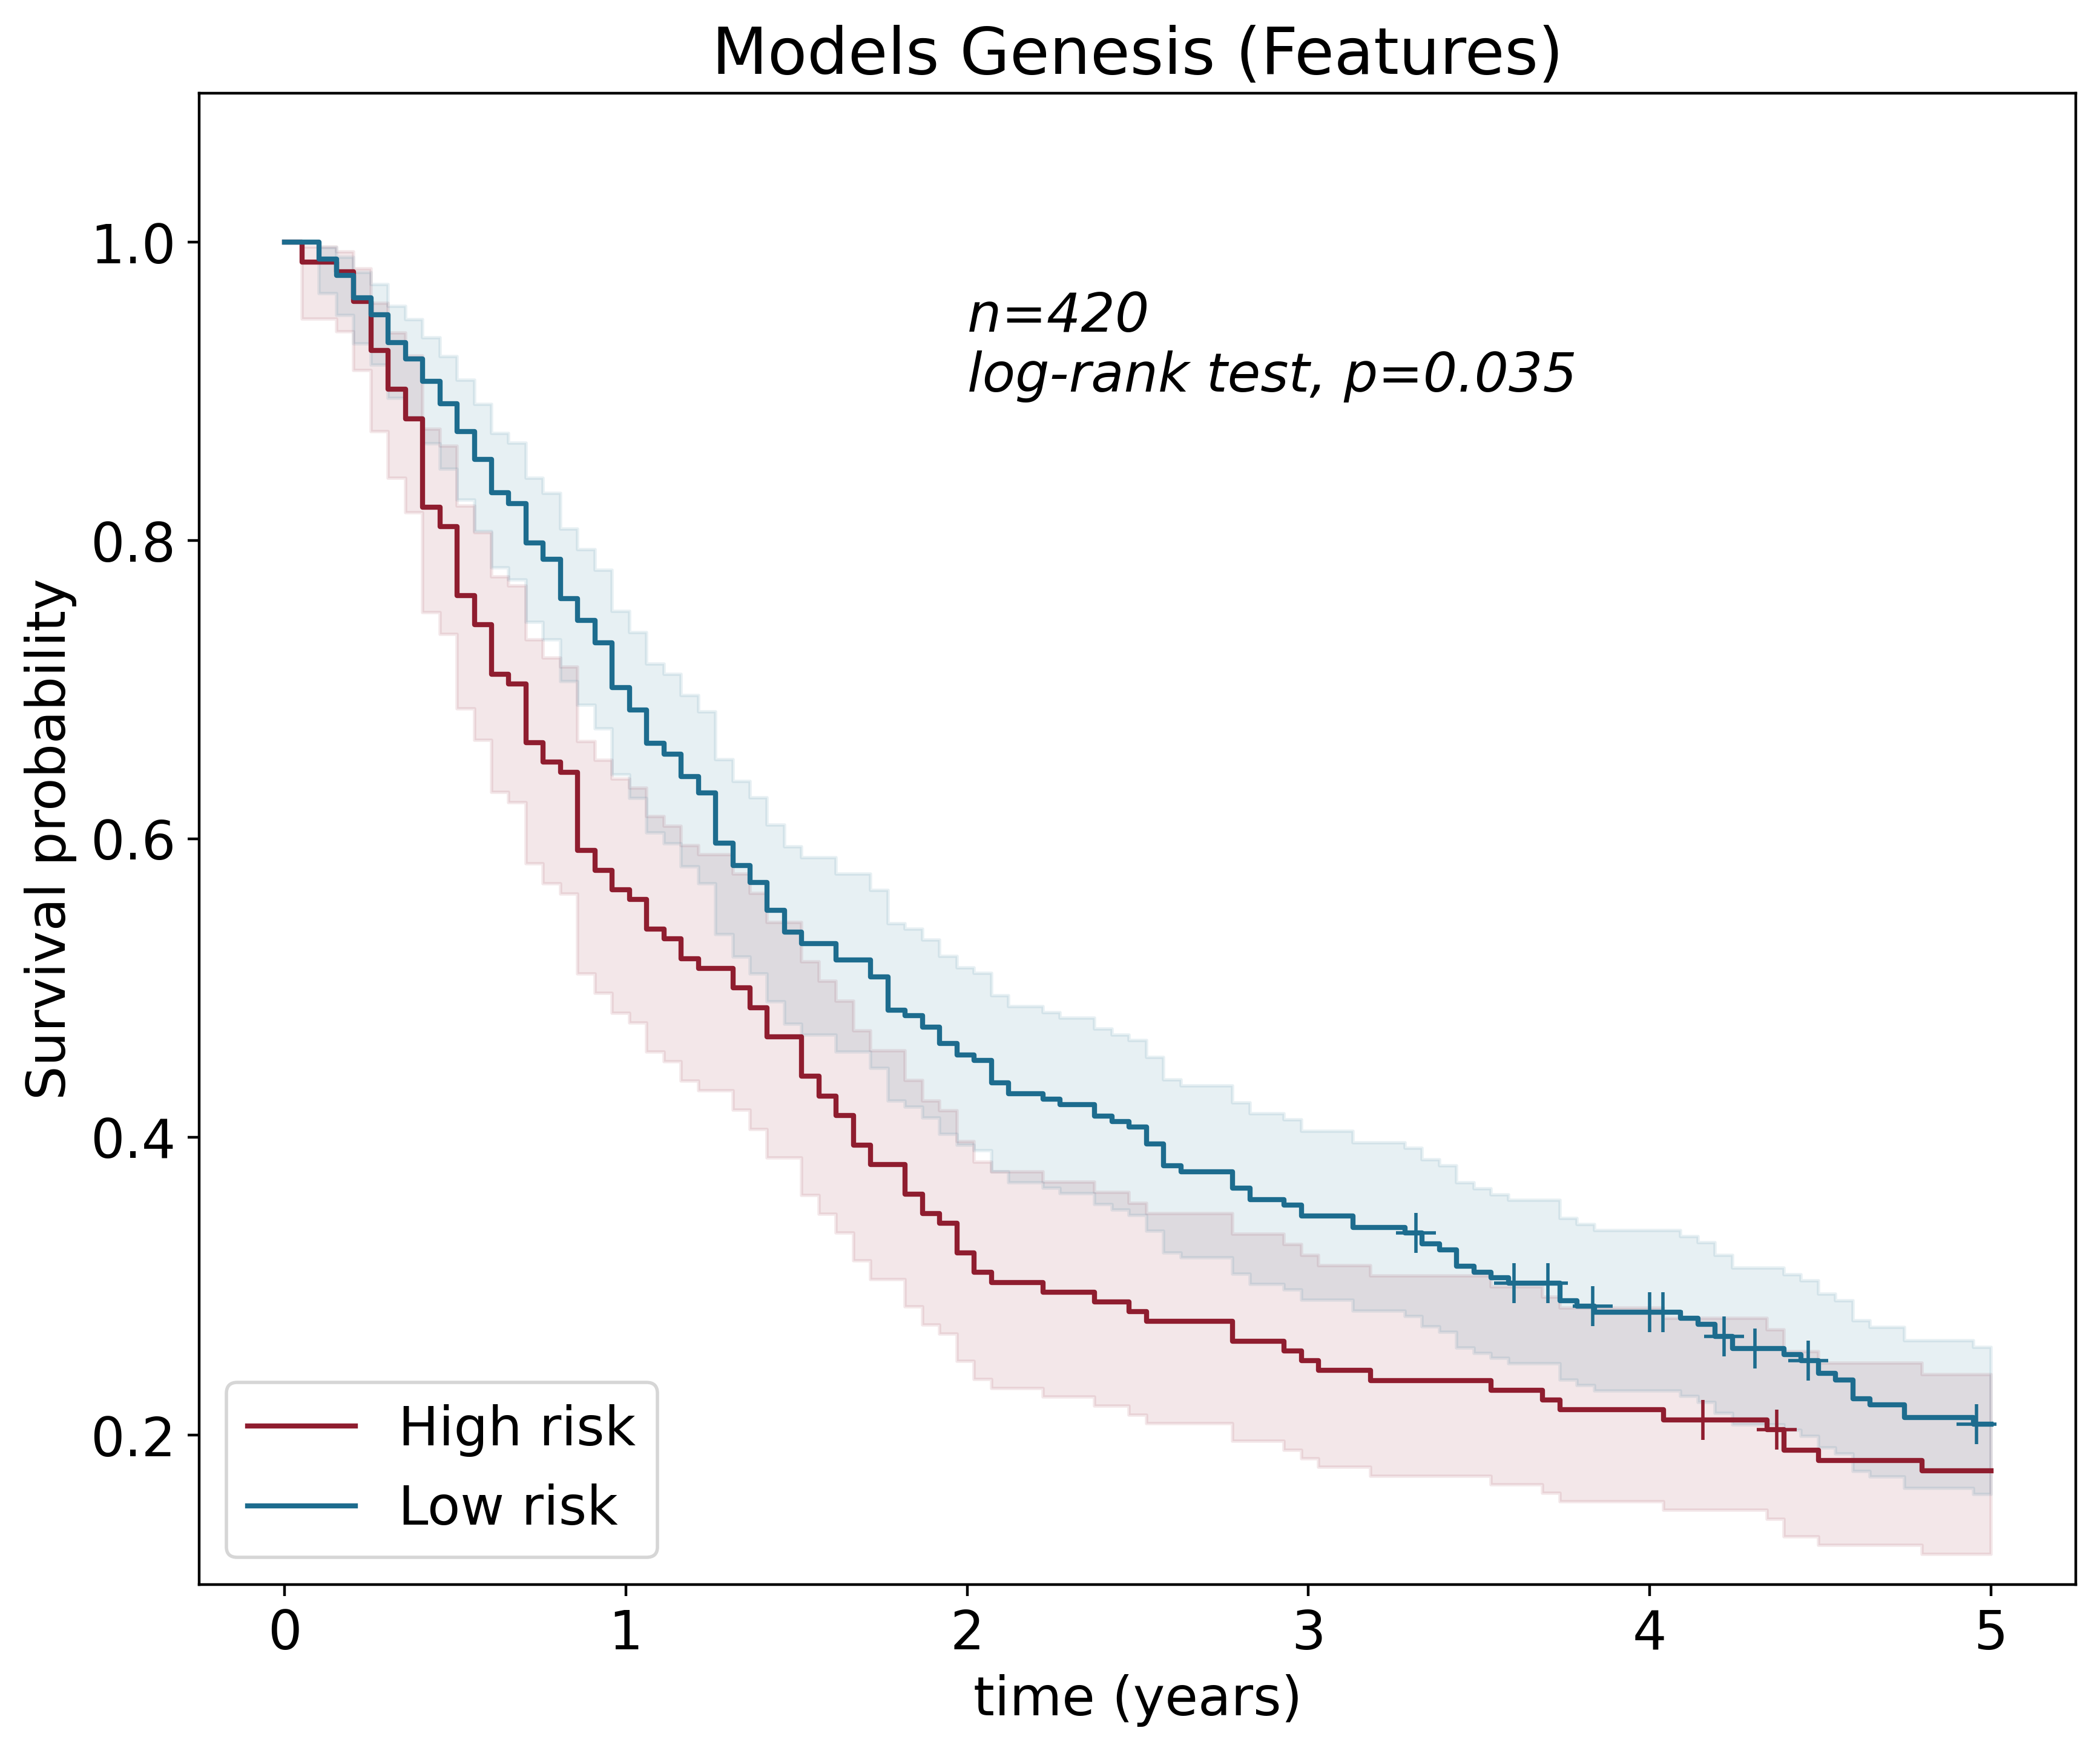

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1968.05
         time fit was run = 2024-01-18 01:14:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.14       1.15       0.11            -0.07             0.36                 0.93                 1.43

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.33 0.18       2.44
---
Concordance = 0.54
Partial AIC = 3938.10
log-likelihood ratio test = 1.74 on 1 df
-log2(p) of ll-ratio test = 2.42

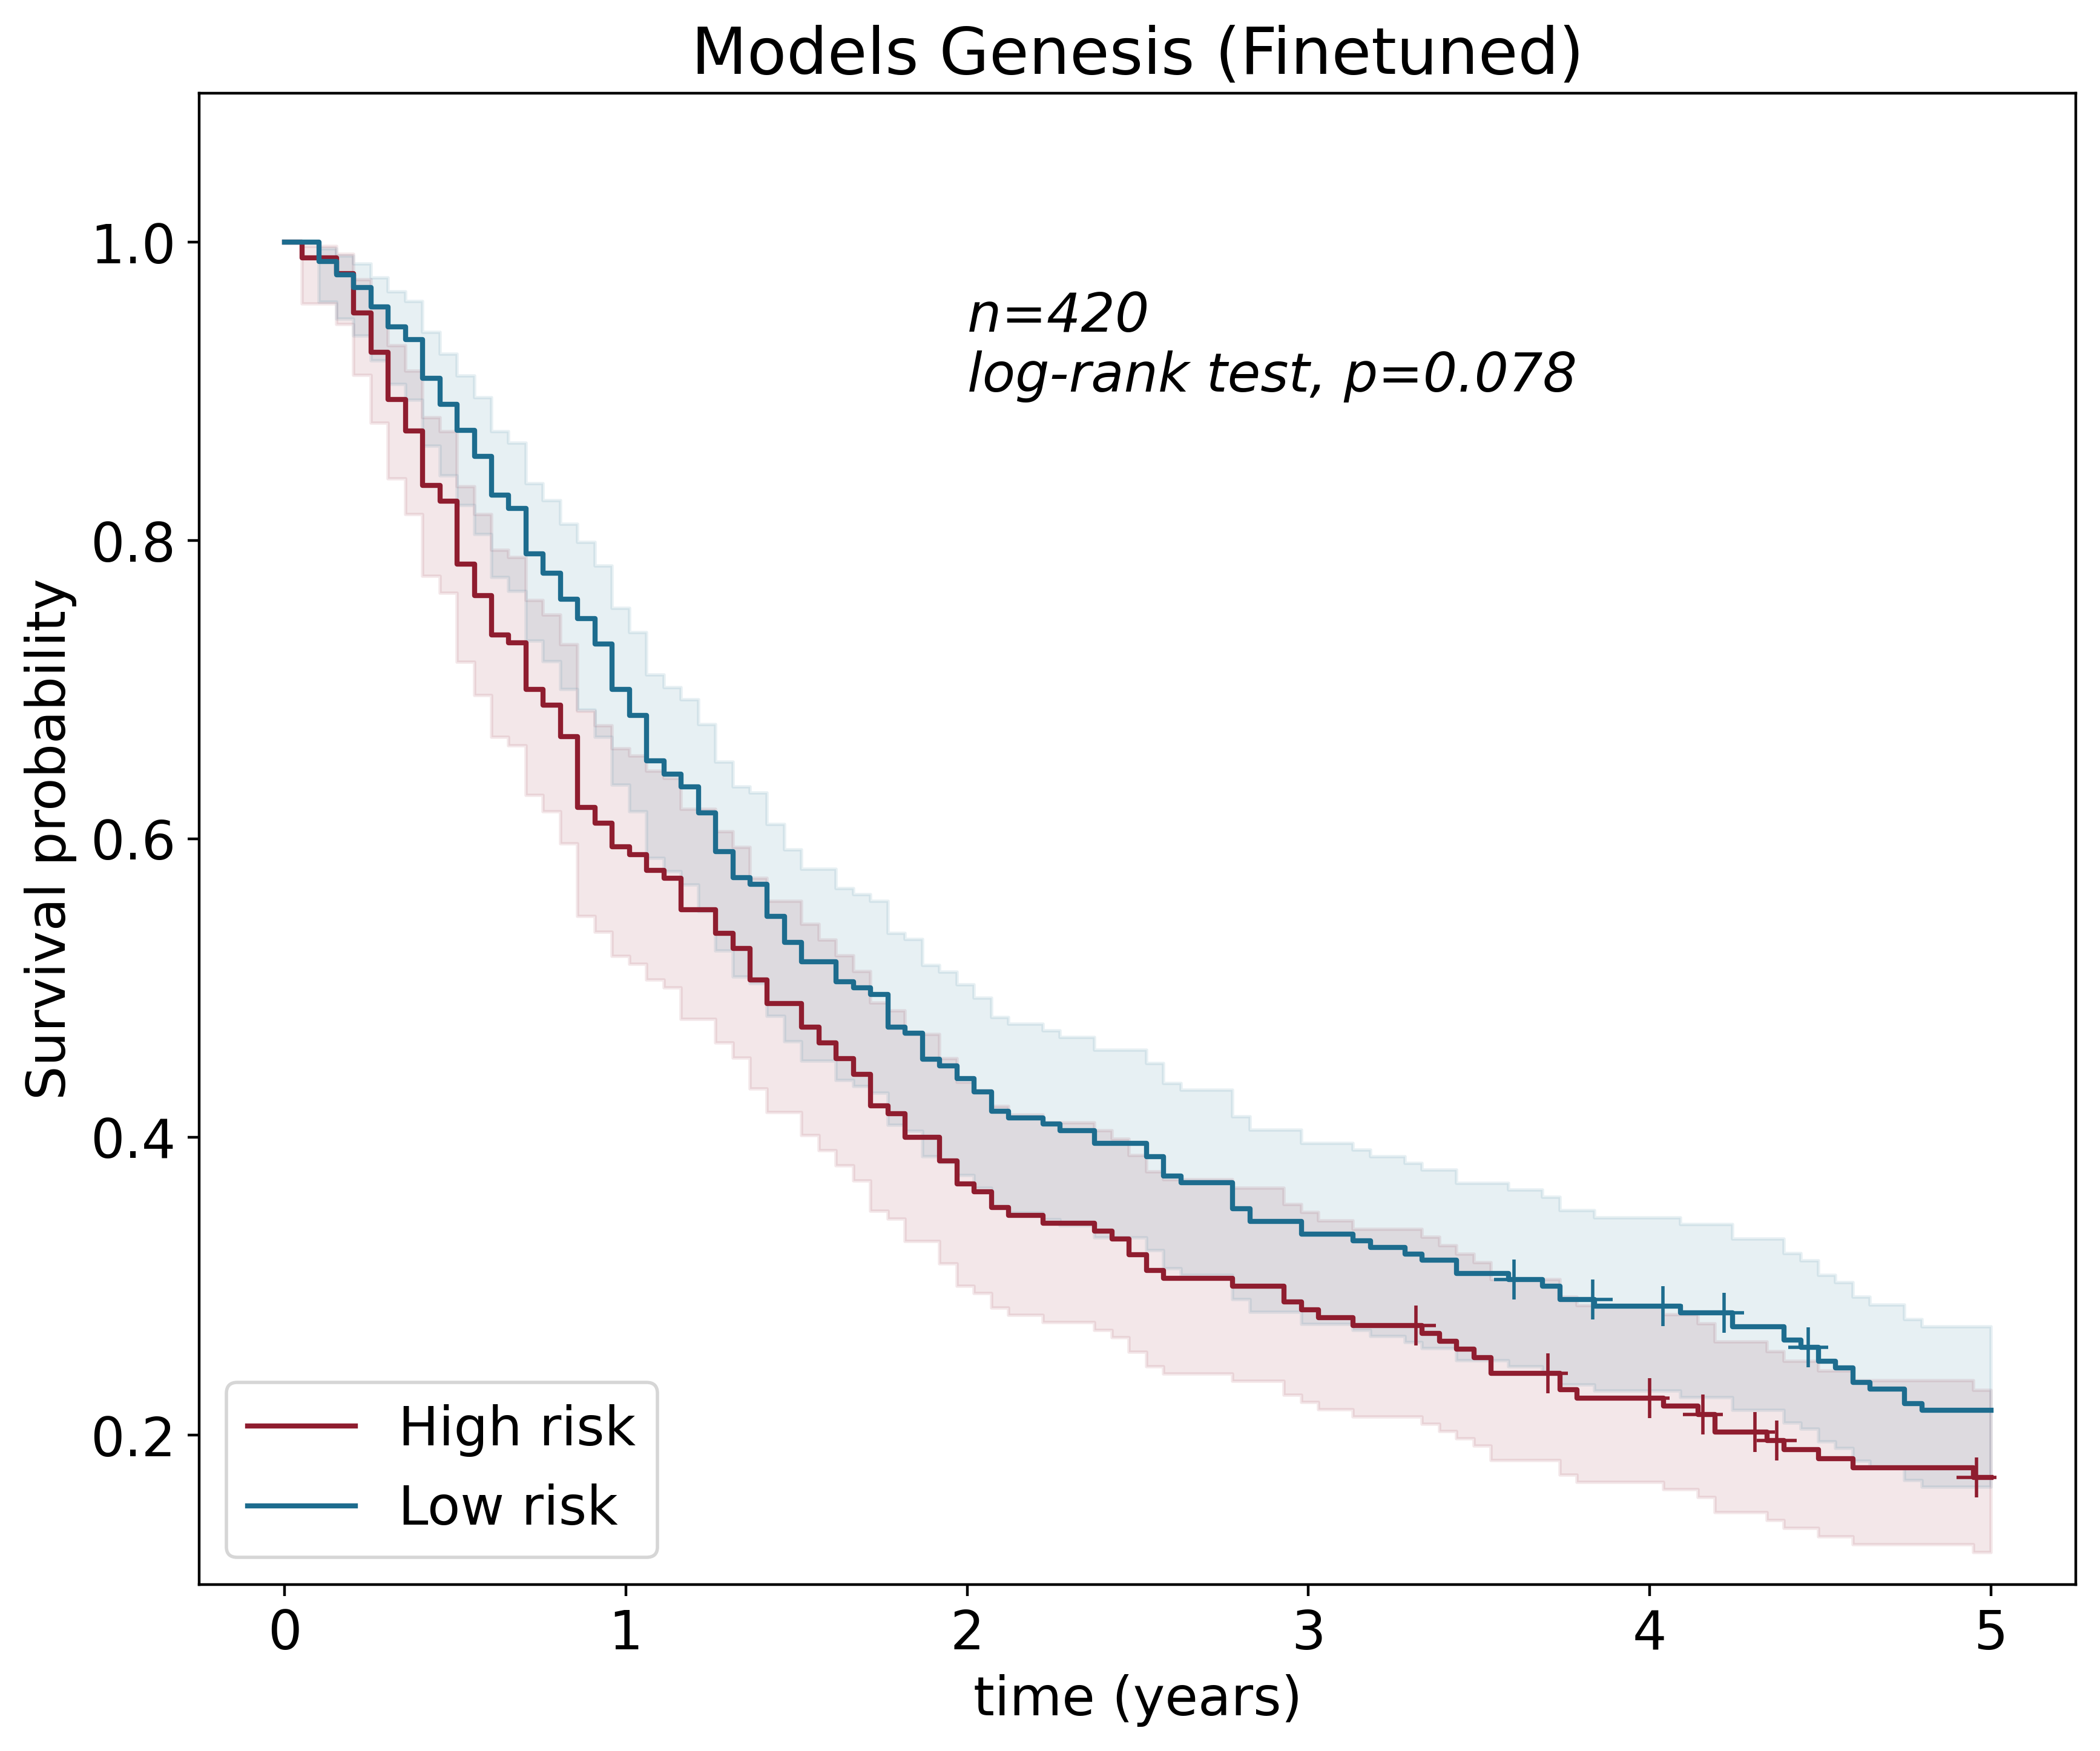

<lifelines.CoxPHFitter: fitted with 420 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 420
number of events observed = 373
   partial log-likelihood = -1968.06
         time fit was run = 2024-01-18 01:14:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.14       1.15       0.10            -0.07             0.34                 0.93                 1.41

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.31 0.19       2.40
---
Concordance = 0.53
Partial AIC = 3938.12
log-likelihood ratio test = 1.72 on 1 df
-log2(p) of ll-ratio test = 2.40

In [11]:
cox_results = {}
for model_implementation, path in lung1_implementation_dict.items():
    df = pd.read_csv(path)
    df["surv2yr"] = (df["Survival.time"] / 365.0 >= 2).astype(int)
    df = df[~((df["surv2yr"] == 0) & (df["deadstatus.event"].astype(int) == 0))]
    median = median_dict[model_implementation]
    lung1_pred = df["conf_scores_class_1"].values if "conf_scores_class_1" in df.columns else df["conf_scores_class"].values
    df.loc[lung1_pred > median, "group"] = "Low risk"
    df.loc[lung1_pred <= median, "group"] = "High risk"
    plot_km_curve(df, title=model_implementation, save_path=f"figures_vector_pdf/task3_lung1_{model_implementation}.pdf")
    df["group"] = (df["group"] == "High risk").astype(int)
    cox_results[model_implementation] = get_univariate_result(df)

In [12]:
cox_results_df = pd.DataFrame(cox_results).T

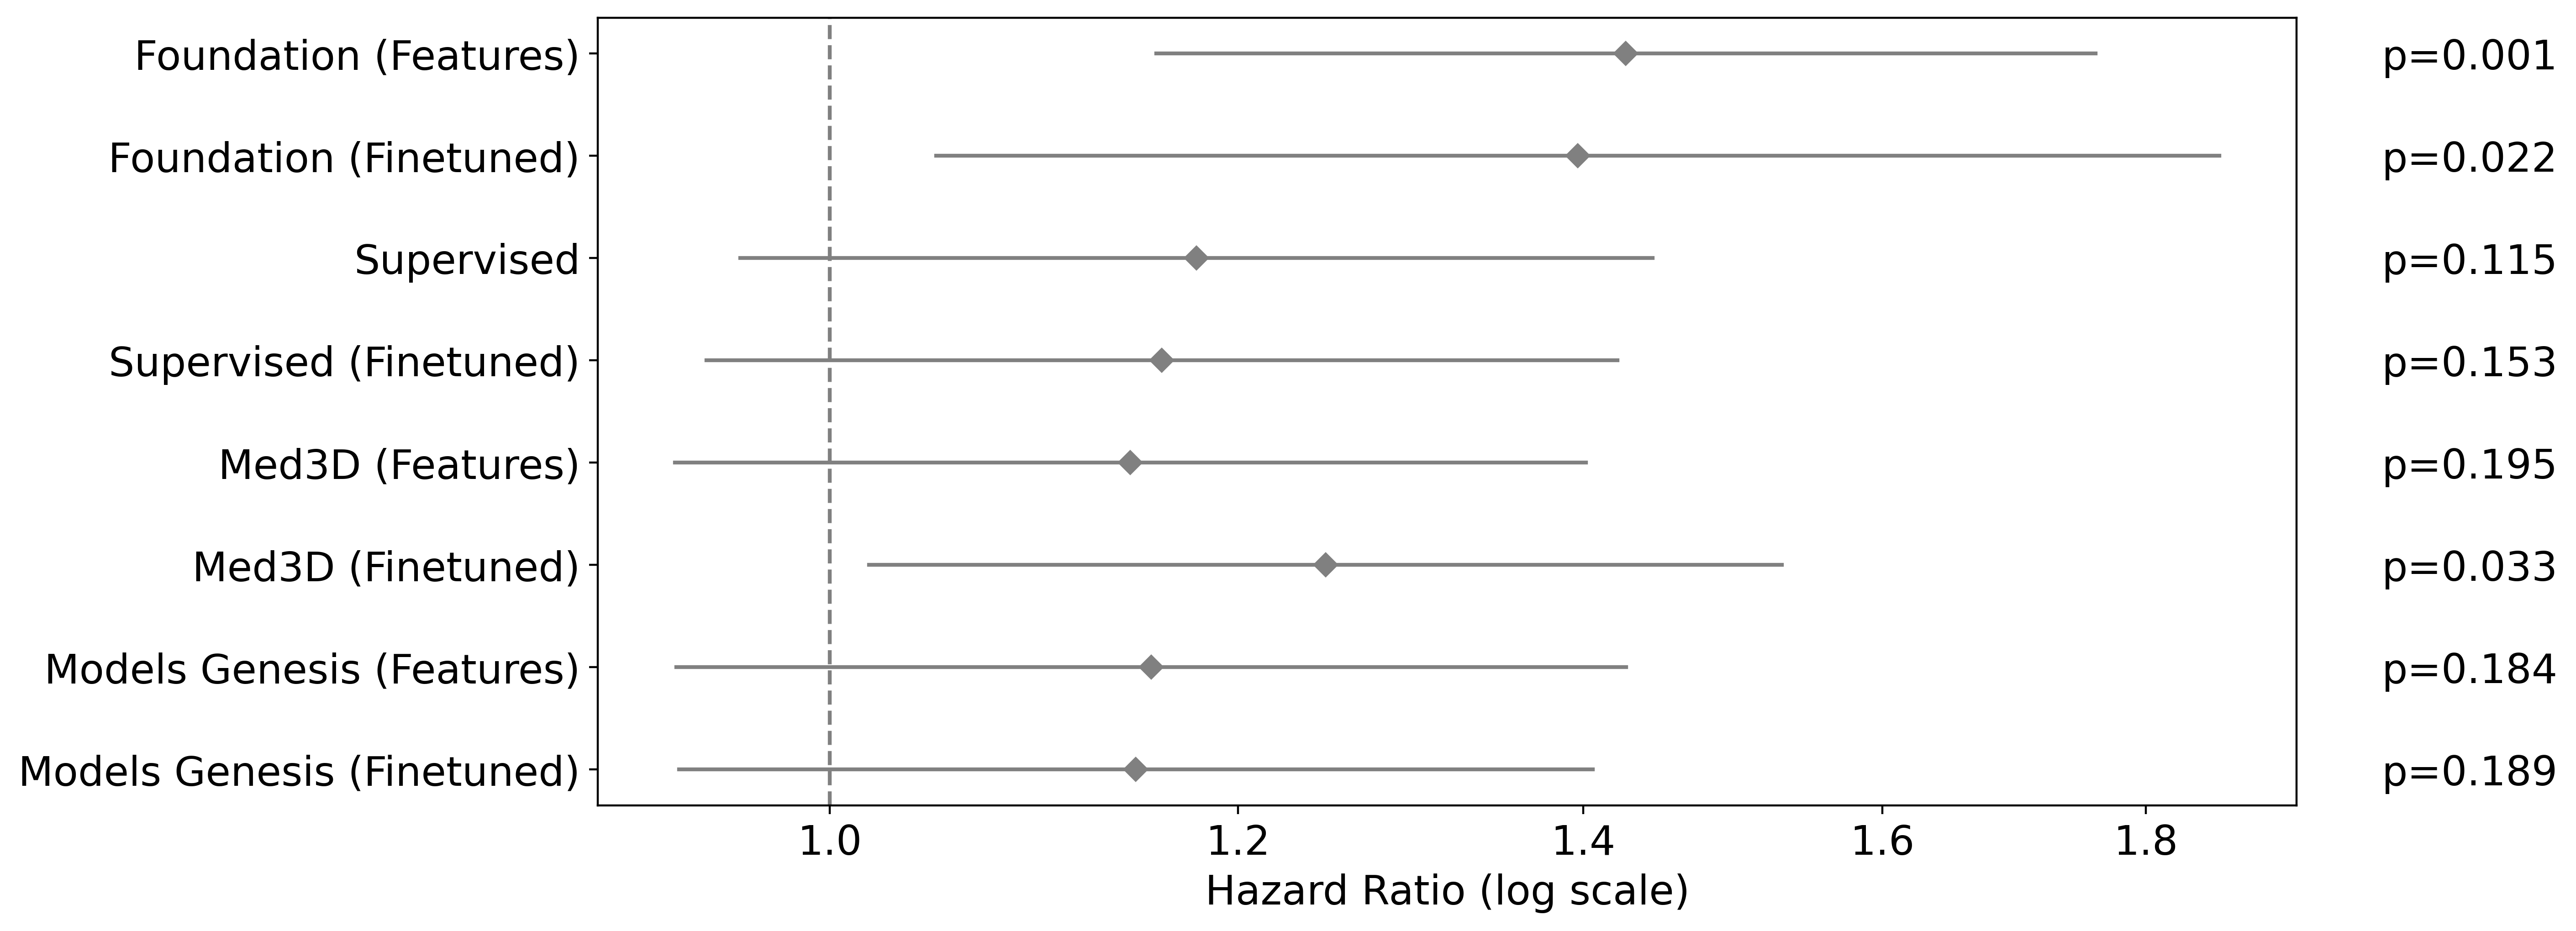

In [13]:
import matplotlib

fig, ax = plt.subplots(figsize=(12, len(cox_results_df) * 0.7))

# For each group, plot a point for HR and a line for the CI
for i, row in cox_results_df[::-1].iterrows():
    ax.plot([row["HR low CI"], row["HR high CI"]], [i, i], "gray")
    ax.plot(row["HR"], i, "D", color="gray")
    ax.text(2.0, i, f'p={row["p.value"]:.3f}', va="center_baseline")

ax.set_yticks(range(len(cox_results_df)))
ax.set_xscale("log")
ax.set_xlabel("Hazard Ratio (log scale)")
ax.set_xticks([1, 1.2, 1.4, 1.6, 1.8])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axvline(1, color="grey", linestyle="--")

plt.savefig("figures_vector_pdf/task3_lung1_cox.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Kaplan Meier Curves for Supervised

### RADIO Dataset

In [14]:
implementation_dict = radio_implementation_dict
pbar = tqdm(total=len(implementation_dict))
results = []

# We use 1000 resamples in the study, but for the sake of time we use reproduce results with 10 here
N_RESAMPLES = 1000

for implementation_name, model_prediction_csv in implementation_dict.items():
    df = pd.read_csv(model_prediction_csv)
    radio_annotations = pd.read_csv("../data/preprocessing/radio/nsclc_radiogenomics.csv")
    radio_annotations["surv2yr"] = (radio_annotations["Survival.time"] / 365.0 >= 2).astype(int)
    radio_annotations = radio_annotations[
        ~((radio_annotations["surv2yr"] == 0) & (radio_annotations["deadstatus.event"].astype(int) == 0))
    ]
    df = df.merge(radio_annotations, on="Case ID", how="inner")
    df.columns = df.columns.str.replace("_y", "")
    pred_set = (
        df["surv2yr"].values,
        df["conf_scores_class_1"].values if "conf_scores_class_1" in df.columns else df["conf_scores_class"].values,
    )
    auc_values = get_model_stats(
        *pred_set,
        fn="roc_auc_score",
        nsamples=N_RESAMPLES,
    )

    row = {
        "Implementation": implementation_name,
        "AUC": np.mean(auc_values),
        "AUC_low_CI": np.percentile(auc_values, 2.5),
        "AUC_high_CI": np.percentile(auc_values, 97.5),
        "AUC_values": auc_values,
        "random_pvalue": scipy.stats.mannwhitneyu(pred_set[1], 1 - pred_set[1]).pvalue,
    }

    # Compute statistics for comparison between this implementation and all other ones (difference CI and p-value)
    compare_impementations = {k: v for k, v in implementation_dict.items() if k != implementation_name}
    for _implementation_name, _model_prediction_csv in compare_impementations.items():
        _df = pd.read_csv(_model_prediction_csv)
        _df = _df.merge(radio_annotations, on="Case ID", how="inner")
        _df.columns = _df.columns.str.replace("_y", "")
        _pred = _df["conf_scores_class_1"].values if "conf_scores_class_1" in _df.columns else _df["conf_scores_class"].values
        _pred_set = (*pred_set, _pred)

        perm_test = get_model_comparison_stats(
            *_pred_set,
            fn="roc_auc_score",
            nsamples=N_RESAMPLES,
        )

        row[f"AUC_diff_CI_low_{_implementation_name}"] = perm_test[0][0]
        row[f"AUC_diff_CI_high_{_implementation_name}"] = perm_test[0][1]
        row[f"AUC_pval_{_implementation_name}"] = perm_test[1]

    results.append(row)
    pbar.update(1)

100%|██████████| 8/8 [17:45<00:00, 133.17s/it]
/tmp/ipykernel_2055403/89312271.py:9: DtypeWarning:

Columns (4101,4105) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4101,4105) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4101,4105) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_2055403/89312271.py:39: DtypeWarning:

Columns (4101,4105) have

In [15]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=["Implementation"], inplace=True, ascending=True)

results_df.to_pickle("radio_results.pkl")

In [9]:
results_df = pd.read_pickle("radio_results.pkl")
results_df["Implementation_Rank"] = results_df["Implementation"].map(implementation_rank)
results_df.sort_values(by=["Implementation_Rank"], inplace=True, ascending=True)
results_df.drop("Implementation_Rank", axis=1, inplace=True)

### Generate the figures
The figures are reproduced using plotly 

In [10]:
for metric in ["AUC"]:
    results_df[f"e_plus_{metric}"] = results_df[f"{metric}_high_CI"] - results_df[metric]
    results_df[f"e_minus_{metric}"] = results_df[metric] - results_df[f"{metric}_low_CI"]
    metric_values = results_df[f"{metric}_values"].values

    colors = ["#3182BD", "#00A3D5", *gray_palette]

    fig = px.bar(
        results_df,
        x="Implementation",
        y=metric,
        error_y=f"e_plus_{metric}",
        error_y_minus=f"e_minus_{metric}",
        color="Implementation",
        template="simple_white",
        labels={"Model": "", metric: metric, "Implementation": "Implementation approaches"},
        color_discrete_sequence=colors,  # Use the blues color palette
        range_y=[0.3, 0.8],
    )

    random_val = np.random.rand(len(metric_values[0]))
    for sample_idx in range(len(metric_values[0])):
        fig.add_trace(
            go.Box(
                x=results_df["Implementation"],
                y=[metric_values[i][sample_idx] for i in range(len(metric_values))],
                marker=dict(color="black", symbol="circle", size=1, line=dict(width=0)),
                fillcolor="rgba(255, 255, 255,0)",
                line=dict(
                    width=0,
                ),
                boxpoints="all",  # display the original data points
                opacity=0.2,
                pointpos=-1.6 + (random_val[sample_idx] * 3.2),
                showlegend=False,
            )
        )

    title = "Full training set"
    fig.update_layout(
        title=title,
        width=600,
        height=500,
        autosize=False,
        legend=dict(
            orientation="v",
        ),
        template="simple_white",
        title_x=0.5,
        bargap=0,
        xaxis=dict(showticklabels=False),
        yaxis=dict(showgrid=True),
        xaxis_title=None,
        showlegend=True,
    ),

    for trace in fig.data:
        if isinstance(trace, go.Bar):
            trace.error_y.thickness = 1

    fig.show()
    fig.write_image(f"figures_vector_pdf/radio_{metric}.pdf")
    fig.data = []

#### Kaplan Meier Curves for Foundation

/tmp/ipykernel_2083549/1726220105.py:3: DtypeWarning:

Columns (4101,4105) have mixed types. Specify dtype option on import or set low_memory=False.



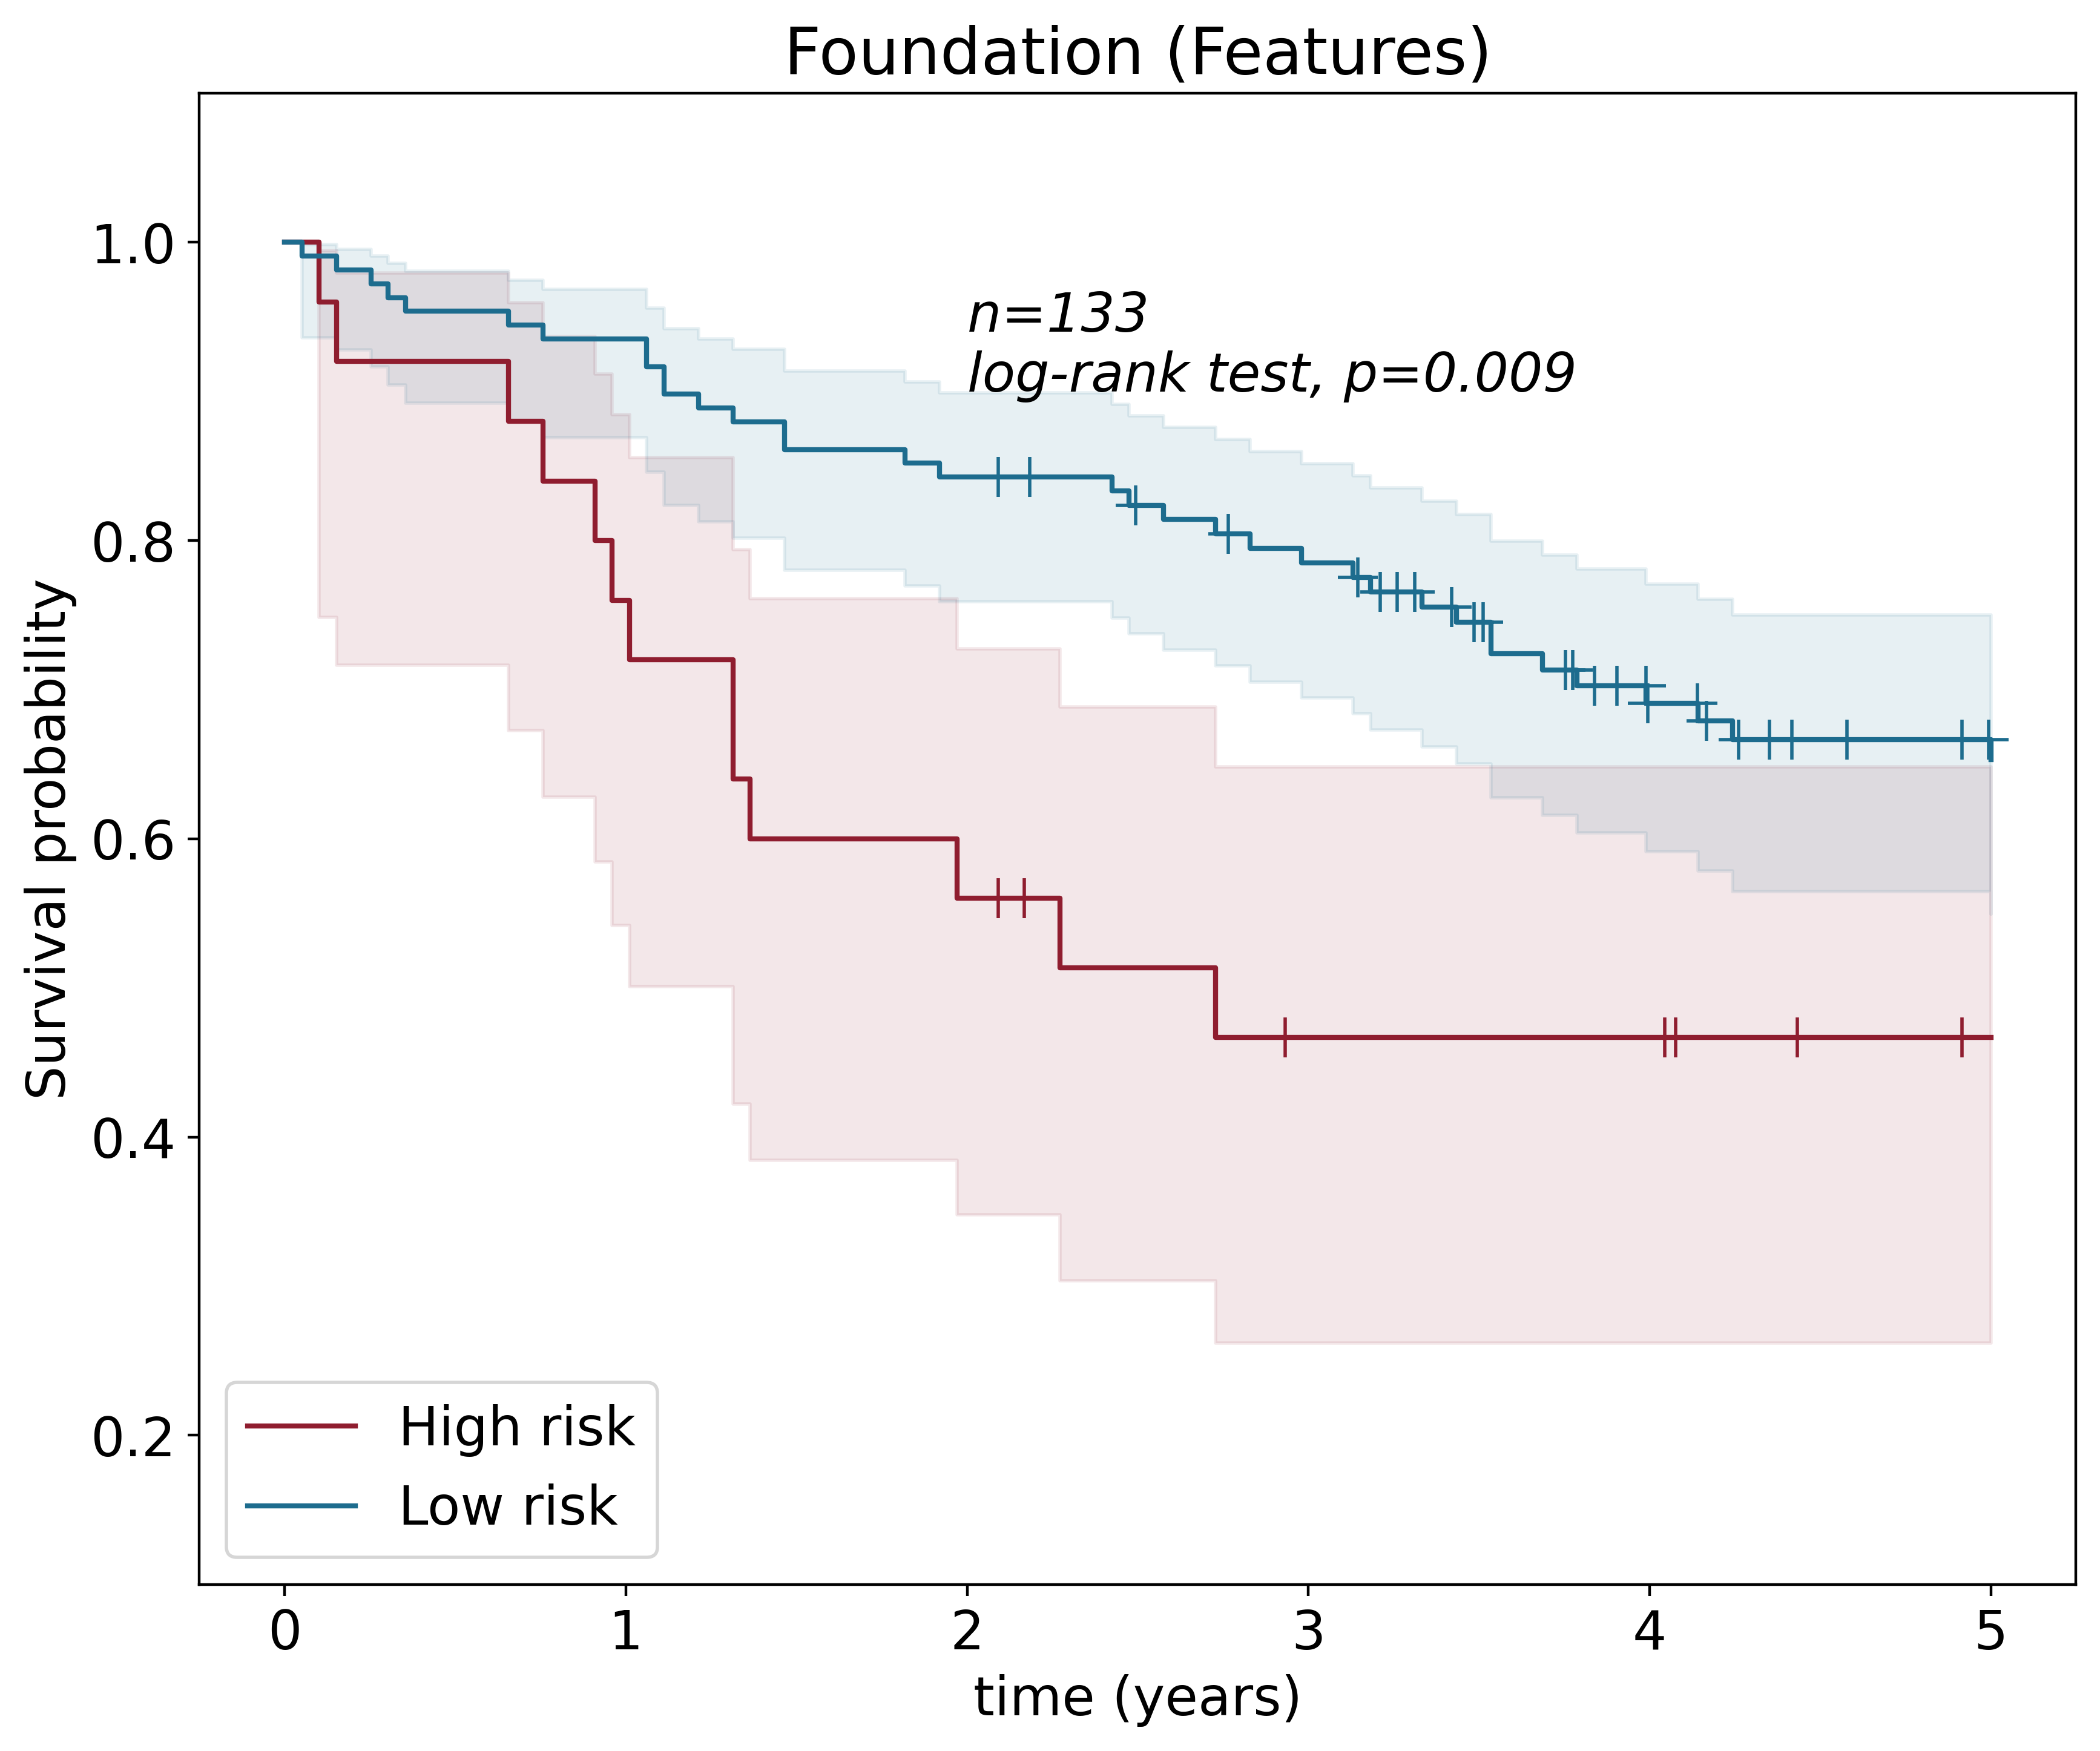

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -228.66
         time fit was run = 2024-01-18 01:31:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.87       2.40       0.32             0.26             1.49                 1.29                 4.46

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 2.77 0.01       7.48
---
Concordance = 0.58
Partial AIC = 459.32
log-likelihood ratio test = 6.64 on 1 df
-log2(p) of ll-ratio test = 6.65

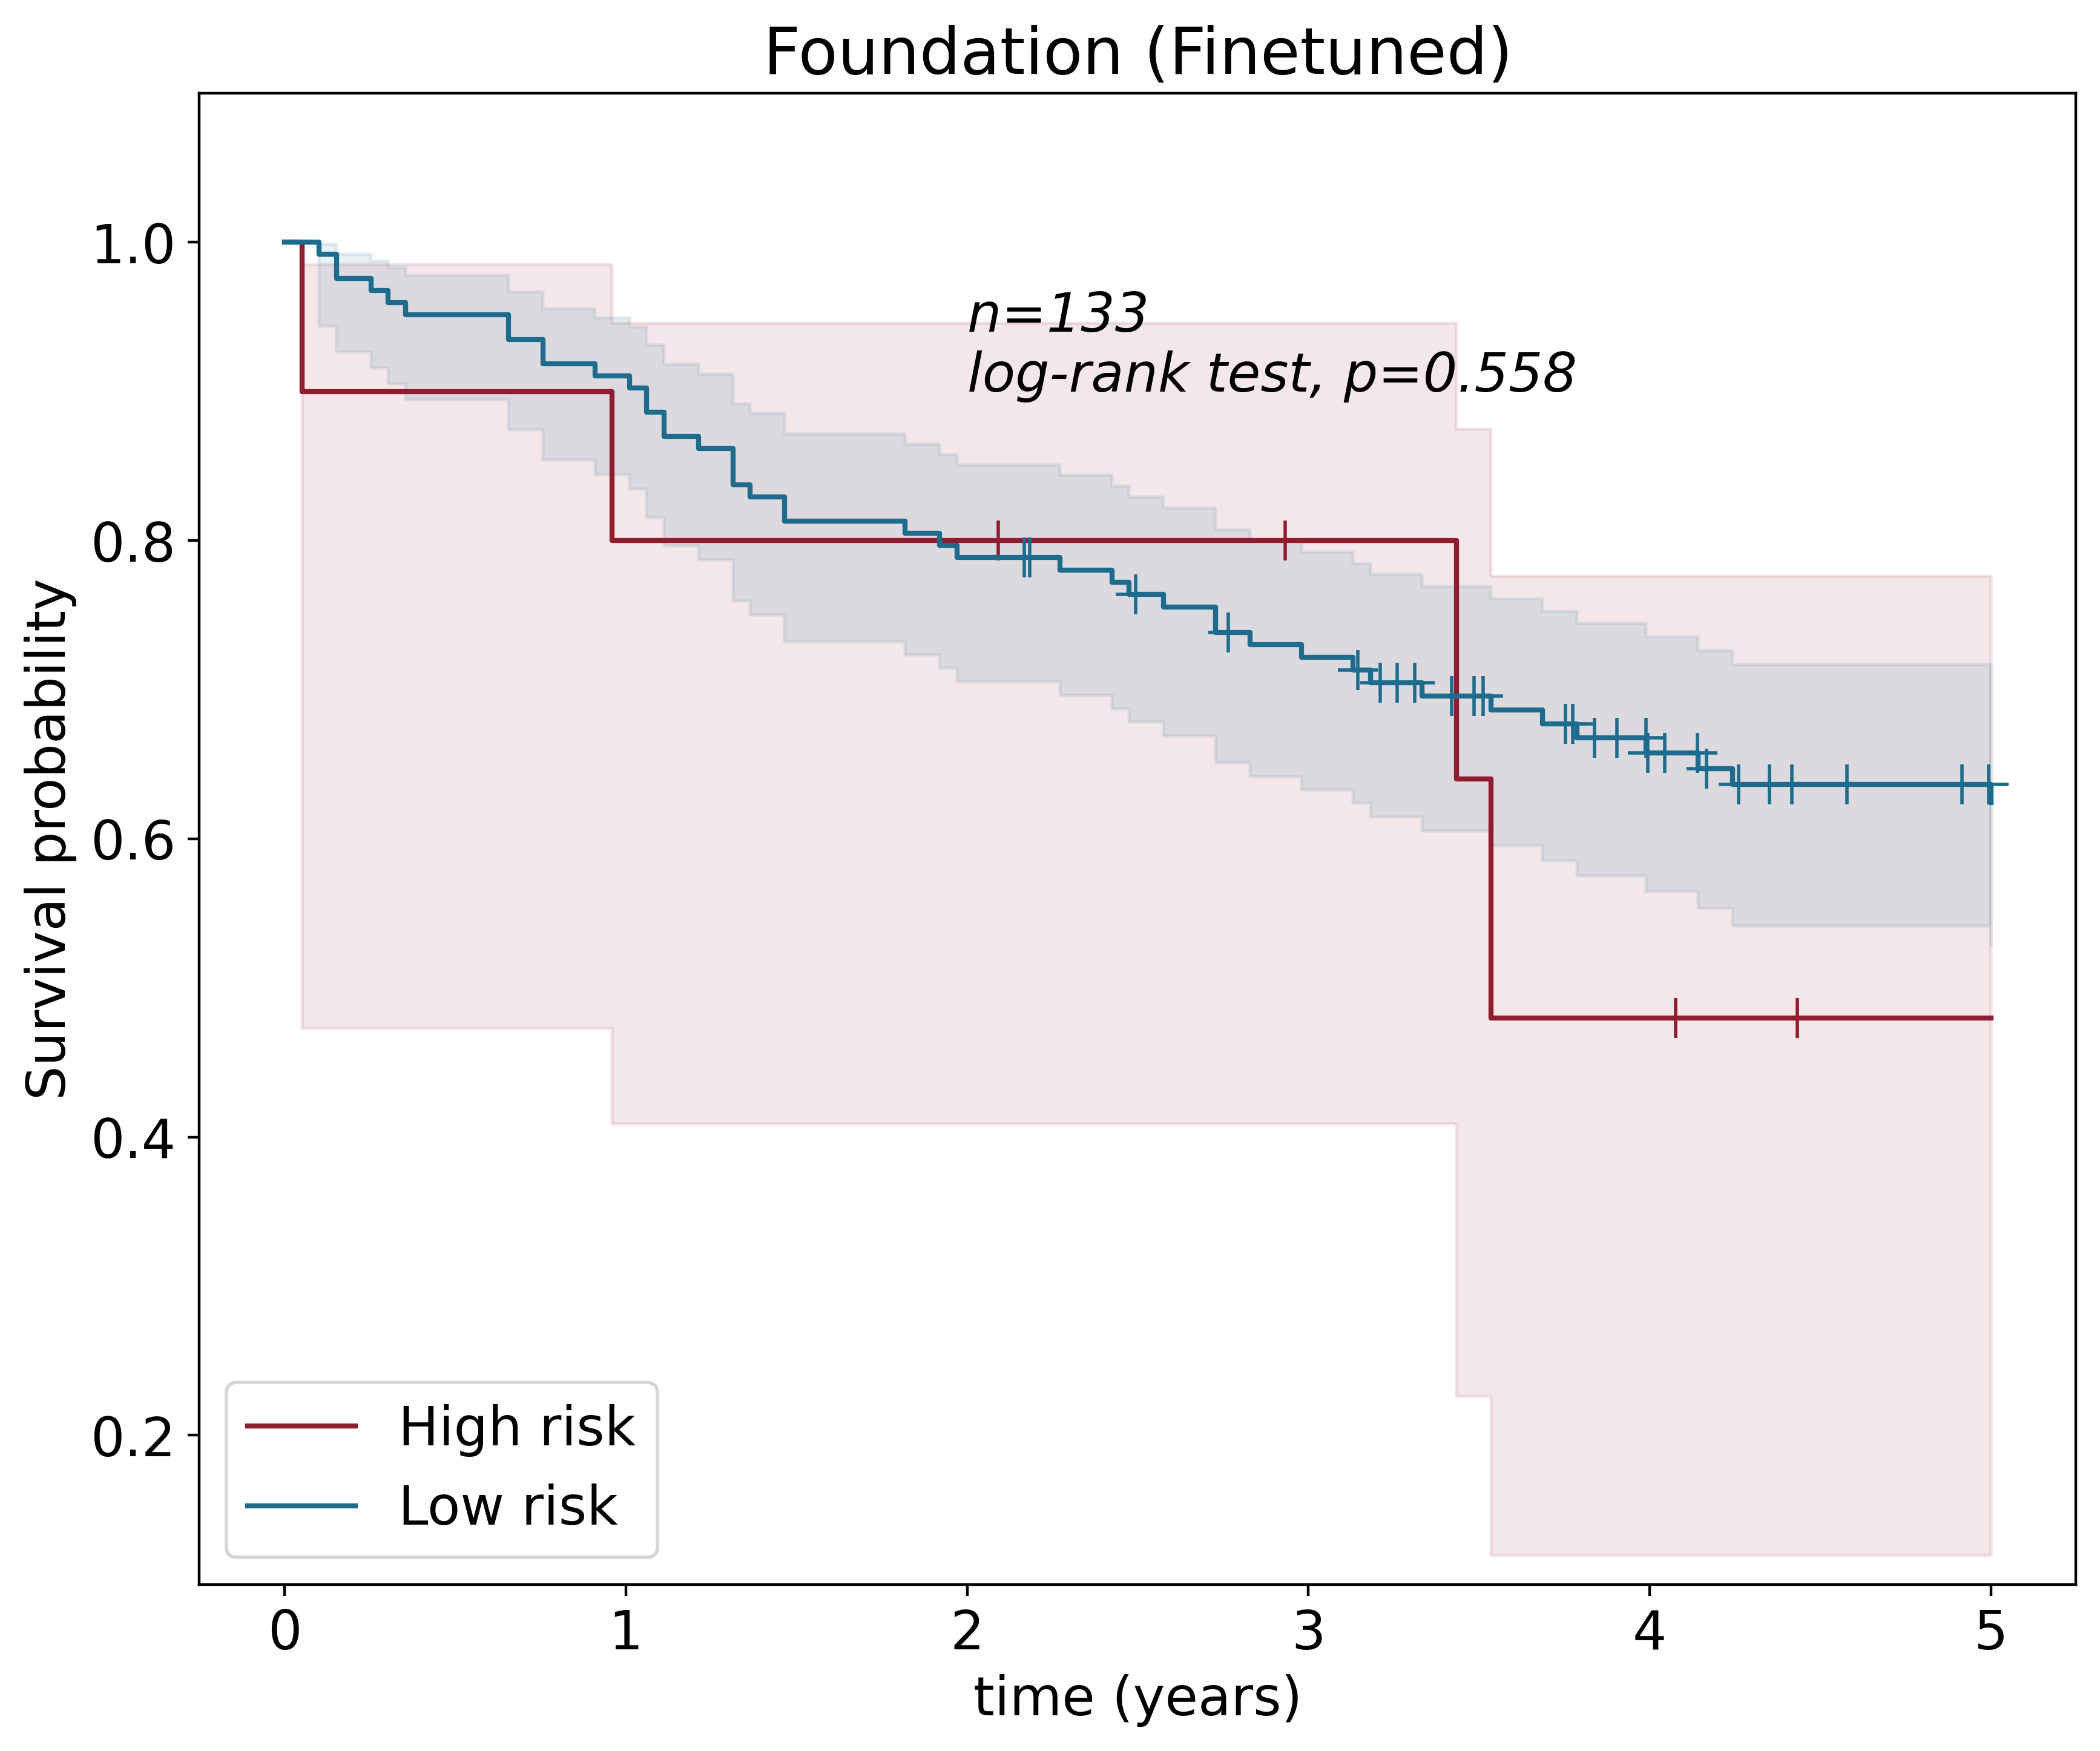

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -231.83
         time fit was run = 2024-01-18 01:32:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.30       1.35       0.52            -0.73             1.32                 0.48                 3.75

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 0.57 0.57       0.81
---
Concordance = 0.51
Partial AIC = 465.66
log-likelihood ratio test = 0.30 on 1 df
-log2(p) of ll-ratio test = 0.77

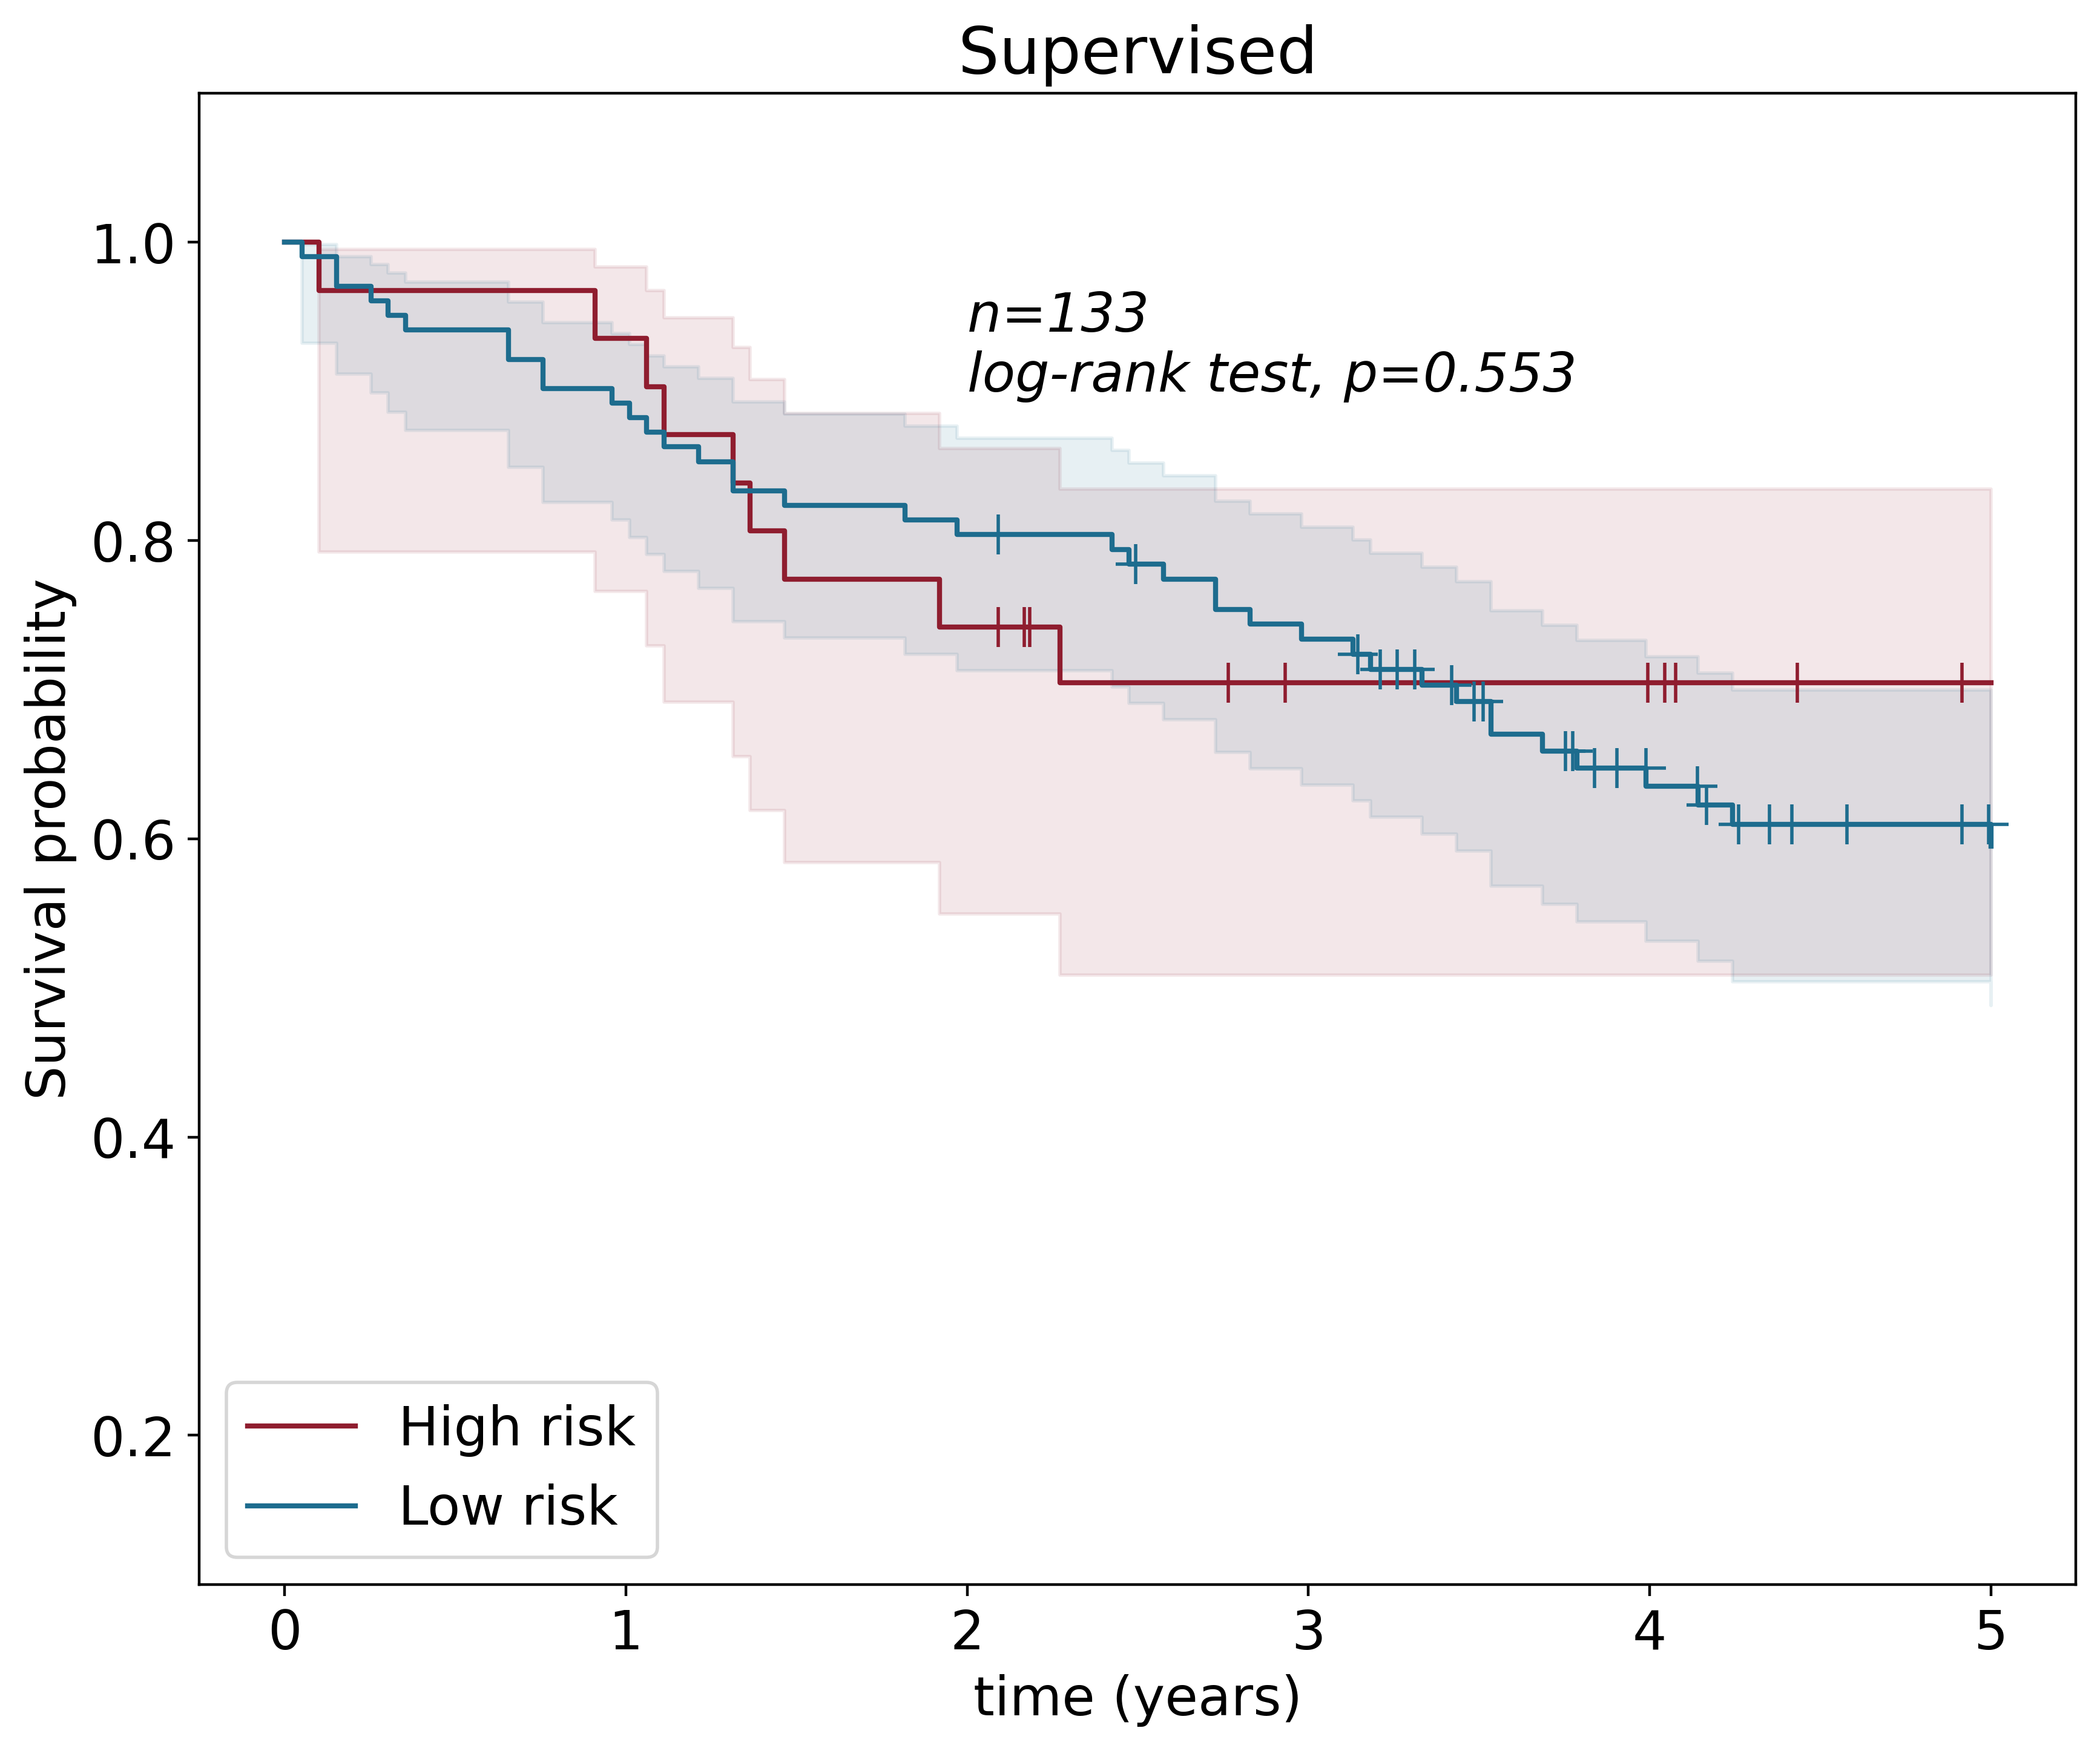

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -231.64
         time fit was run = 2024-01-18 01:32:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group      -0.29       0.74       0.37            -1.01             0.43                 0.36                 1.53

            cmp to     z    p   -log2(p)
covariate                               
group         0.00 -0.80 0.42       1.24
---
Concordance = 0.51
Partial AIC = 465.28
log-likelihood ratio test = 0.68 on 1 df
-log2(p) of ll-ratio test = 1.29

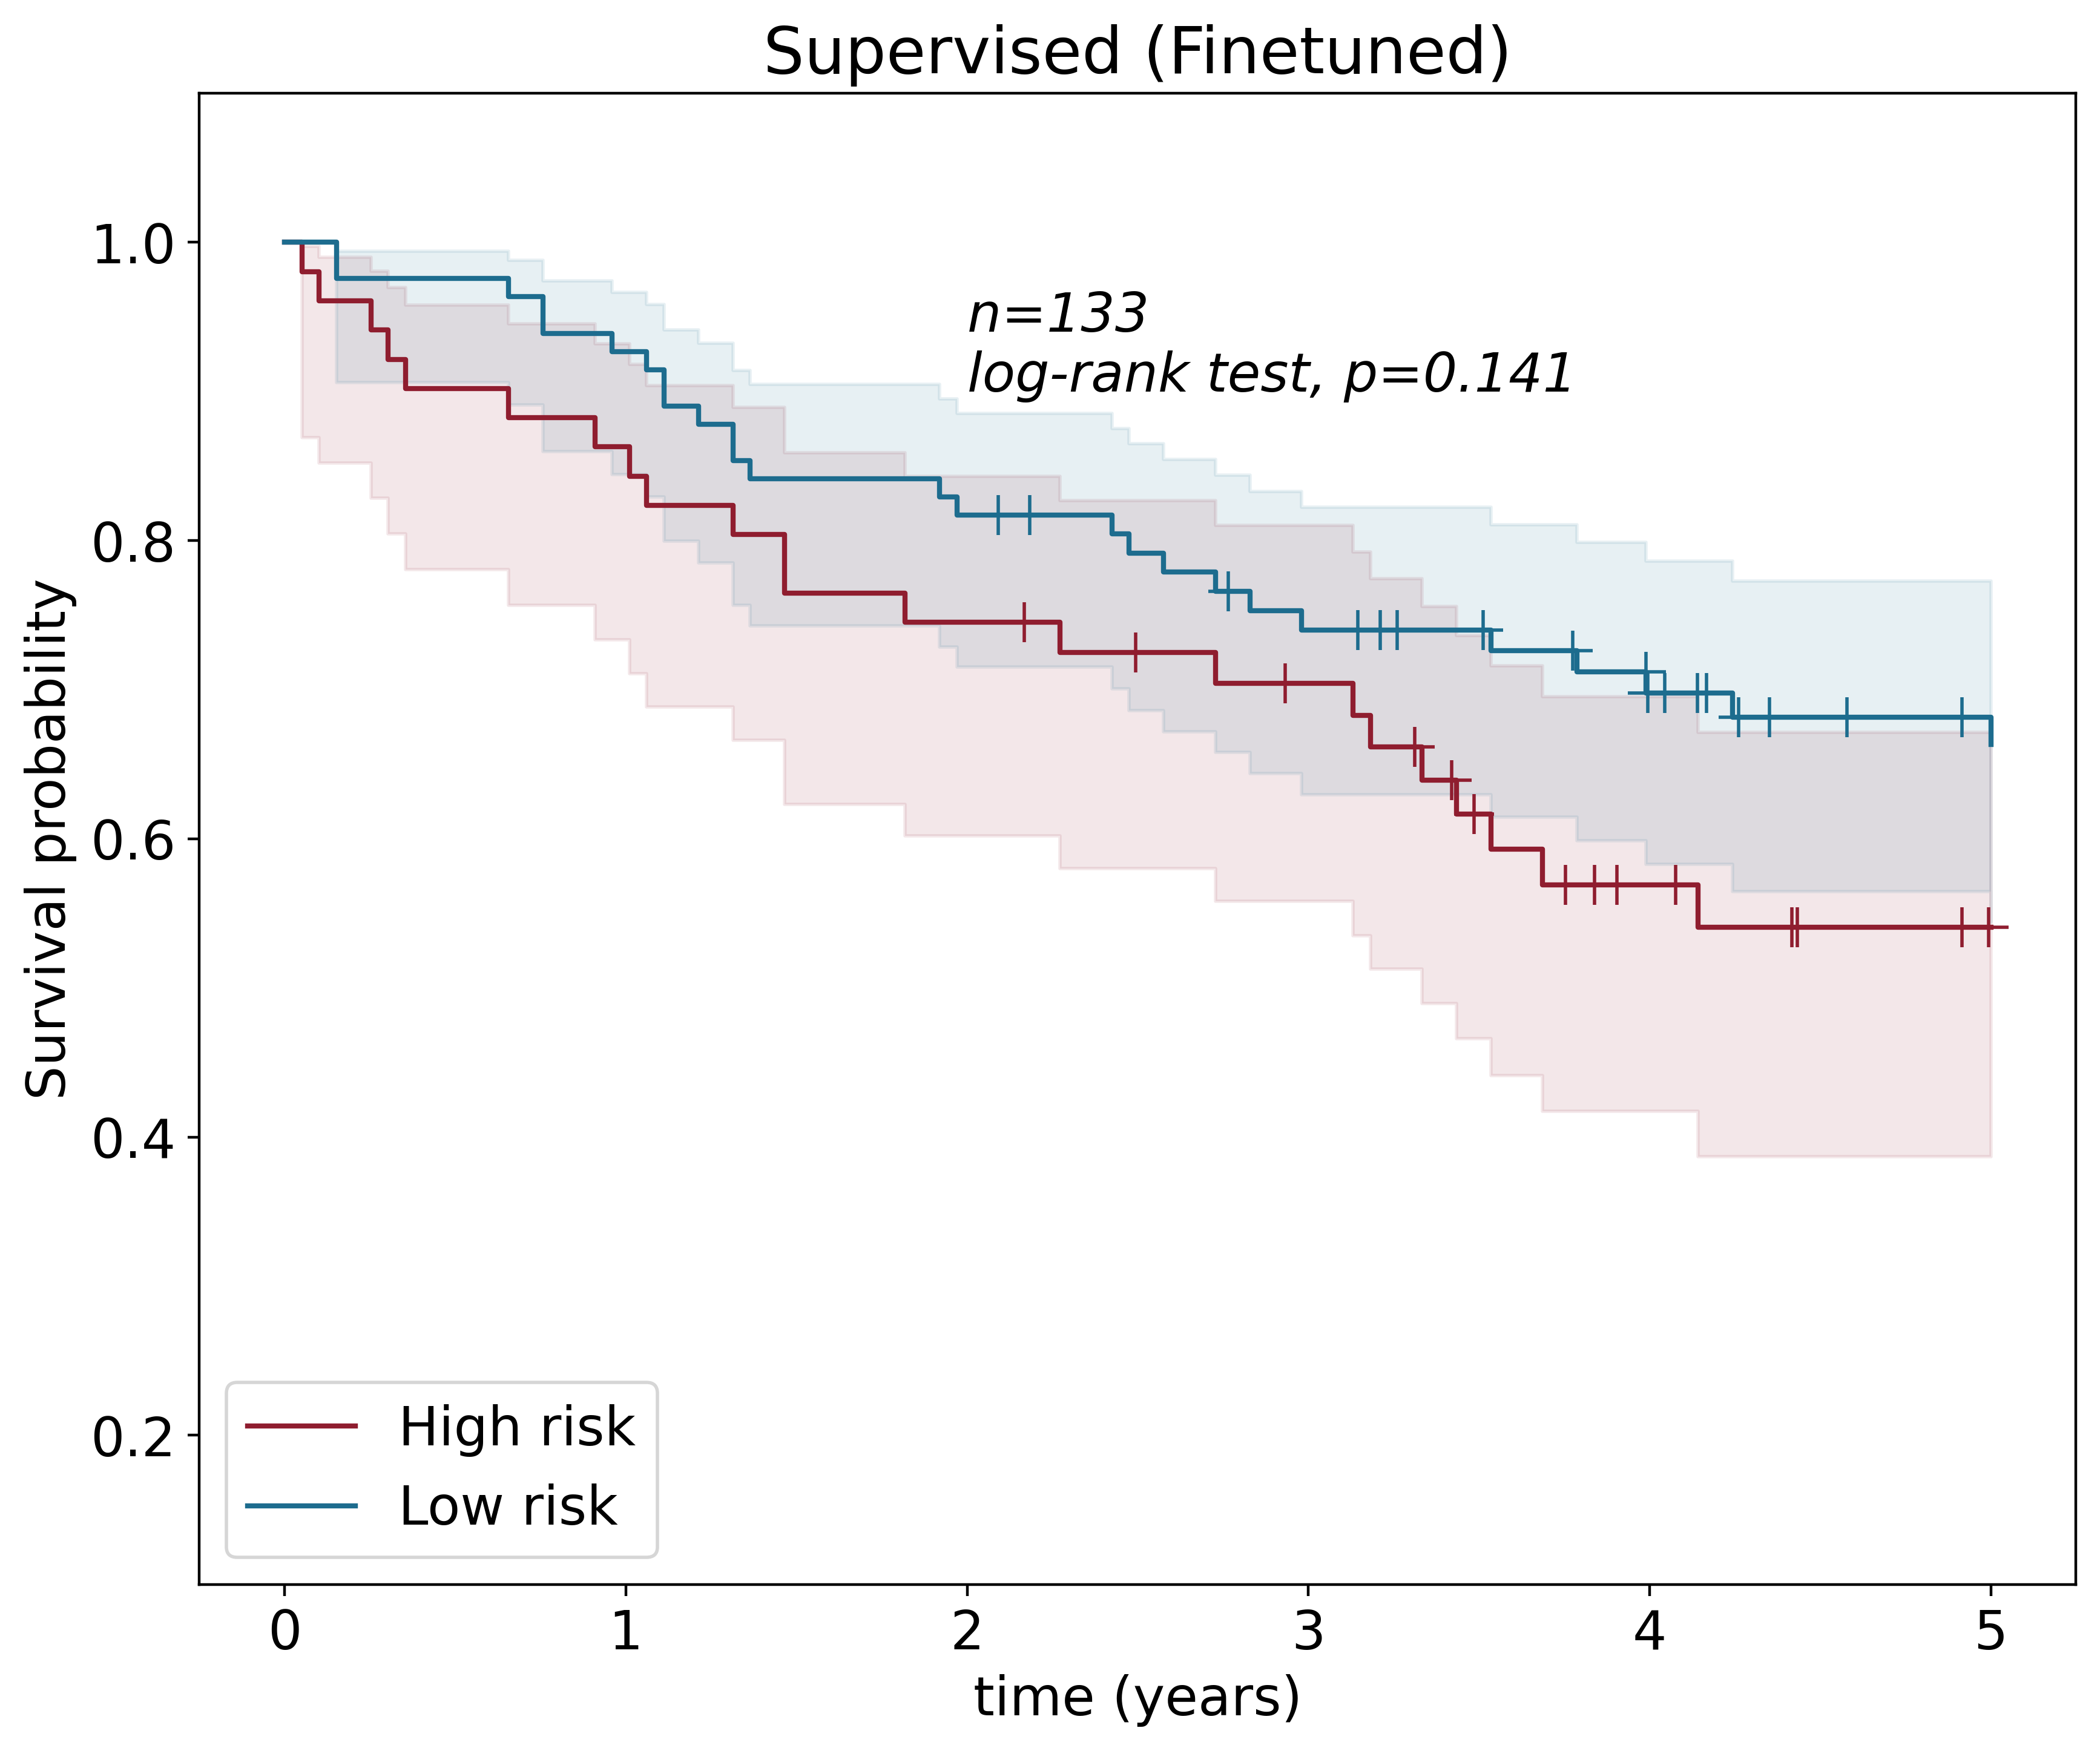

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -230.41
         time fit was run = 2024-01-18 01:32:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.50       1.65       0.28            -0.05             1.05                 0.95                 2.87

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.79 0.07       3.76
---
Concordance = 0.56
Partial AIC = 462.82
log-likelihood ratio test = 3.13 on 1 df
-log2(p) of ll-ratio test = 3.71

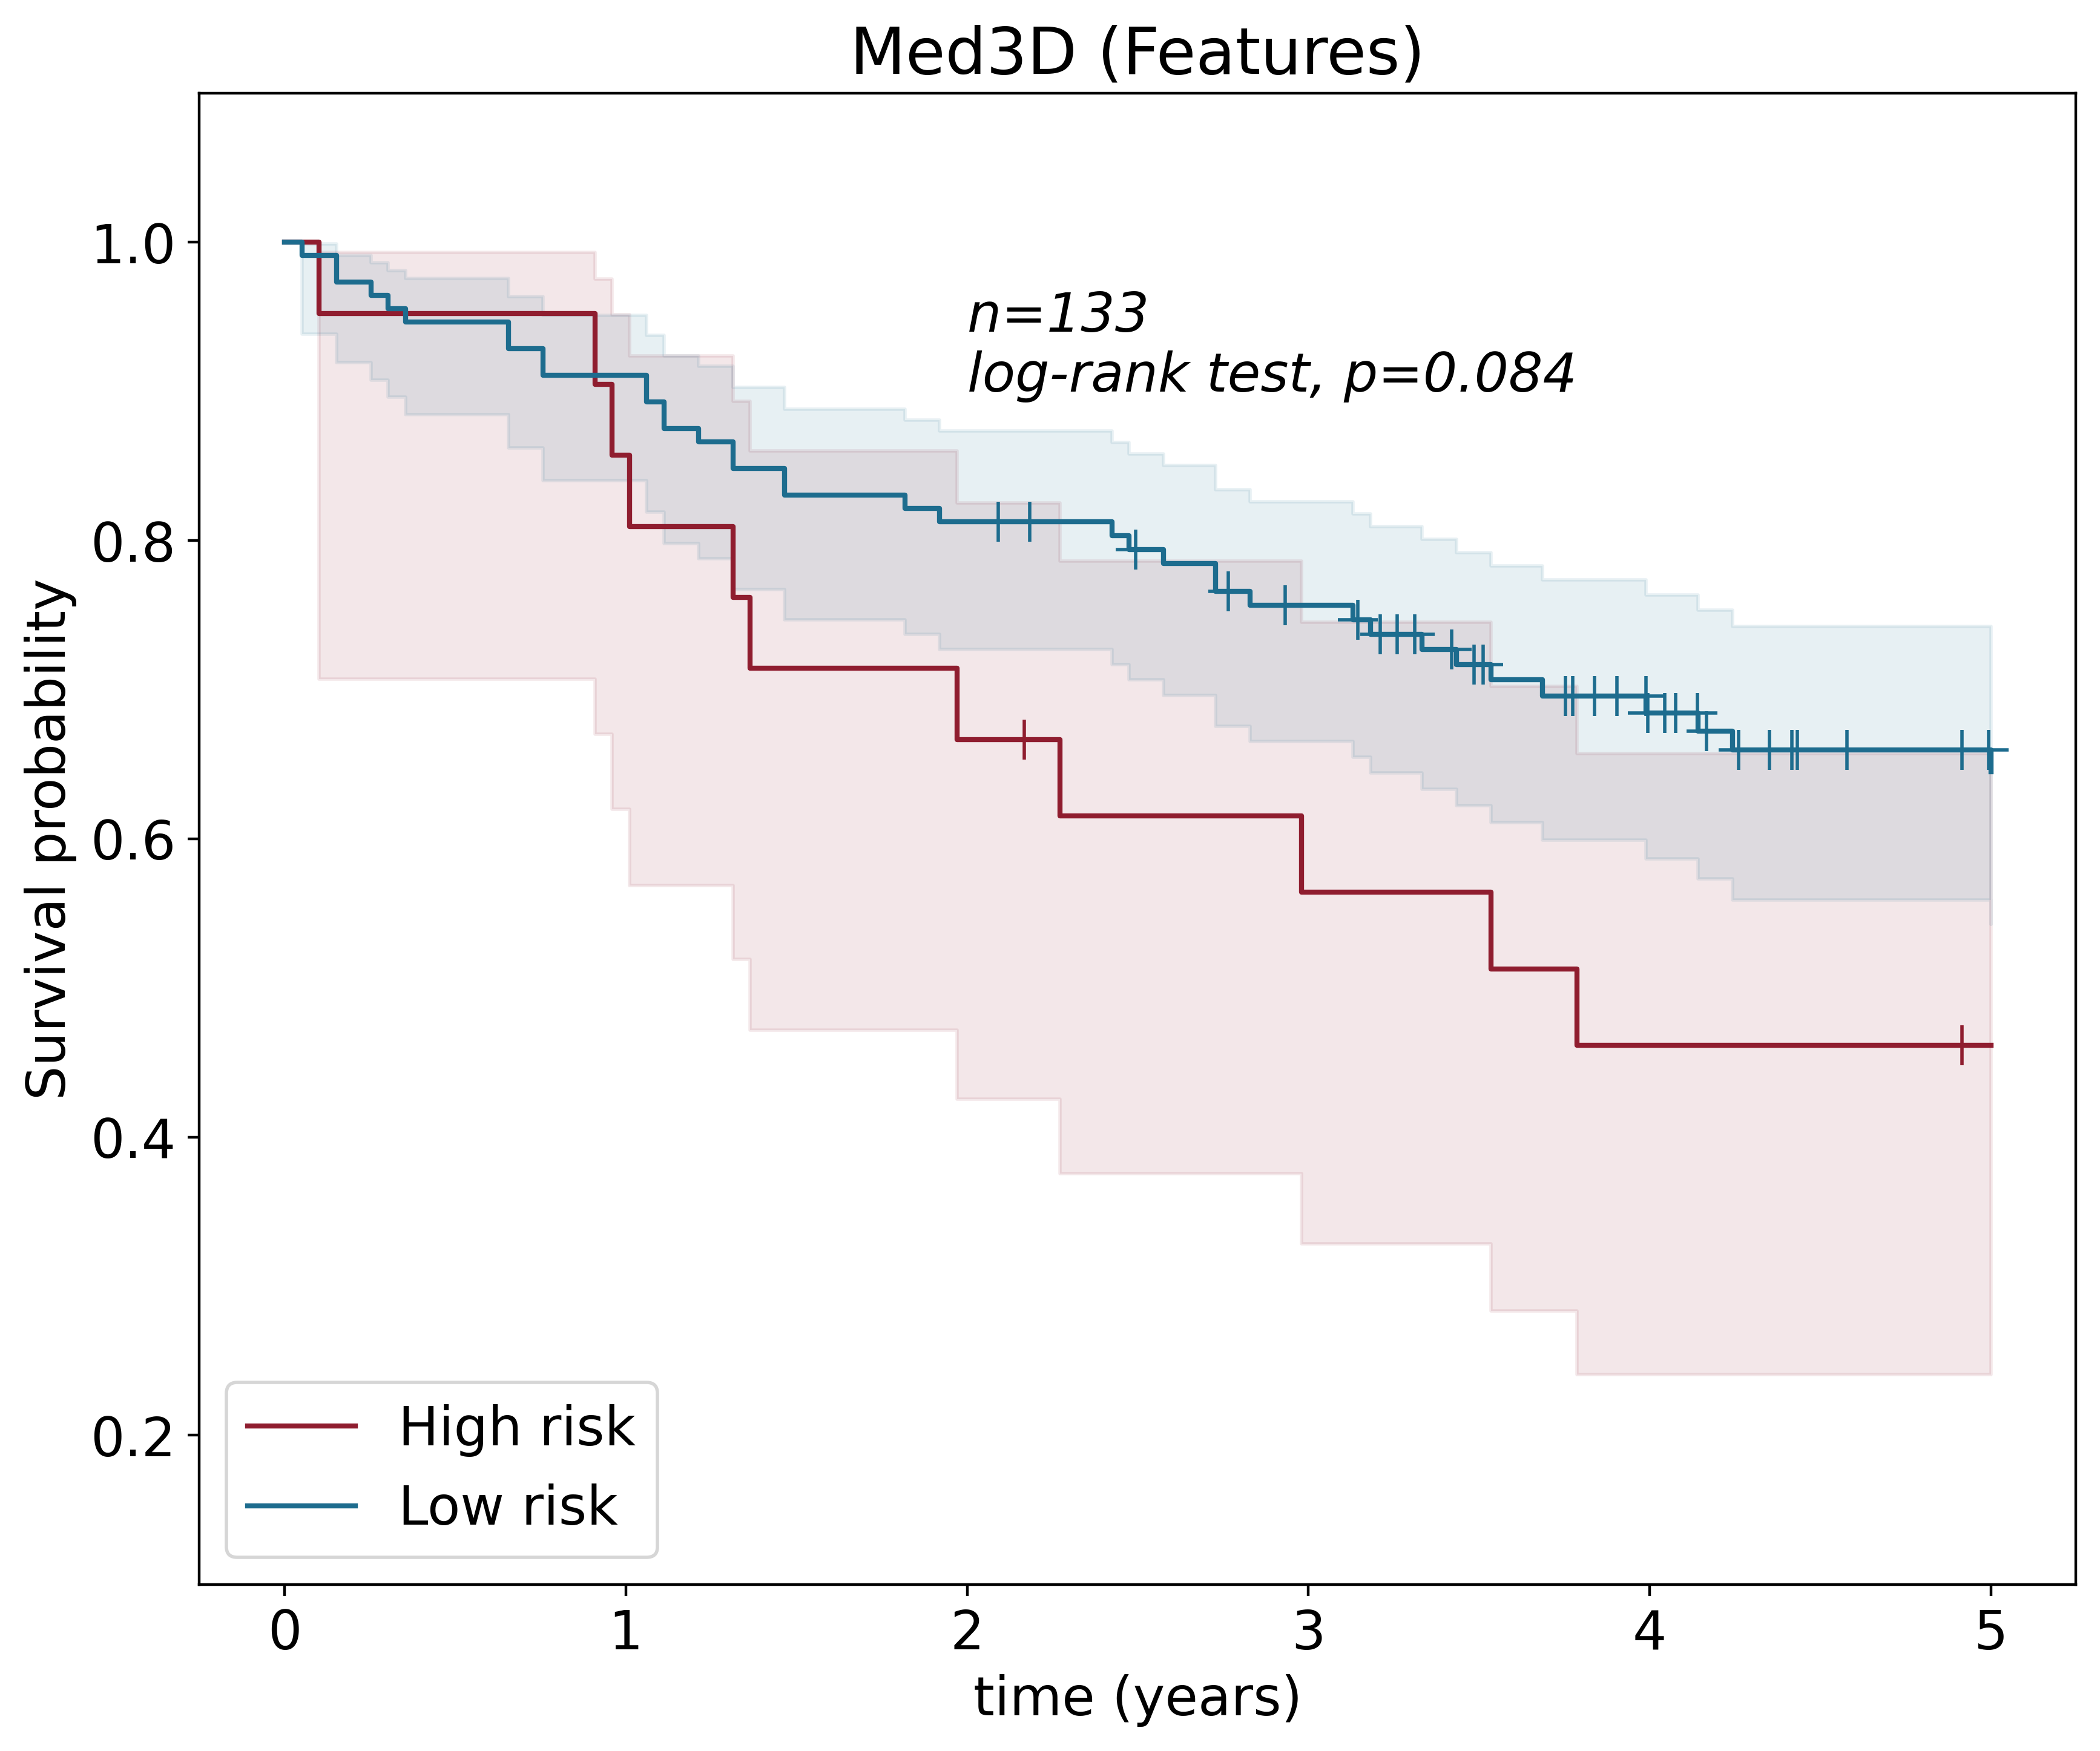

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -230.37
         time fit was run = 2024-01-18 01:32:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.63       1.88       0.33            -0.02             1.28                 0.98                 3.59

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 1.90 0.06       4.13
---
Concordance = 0.55
Partial AIC = 462.74
log-likelihood ratio test = 3.22 on 1 df
-log2(p) of ll-ratio test = 3.78

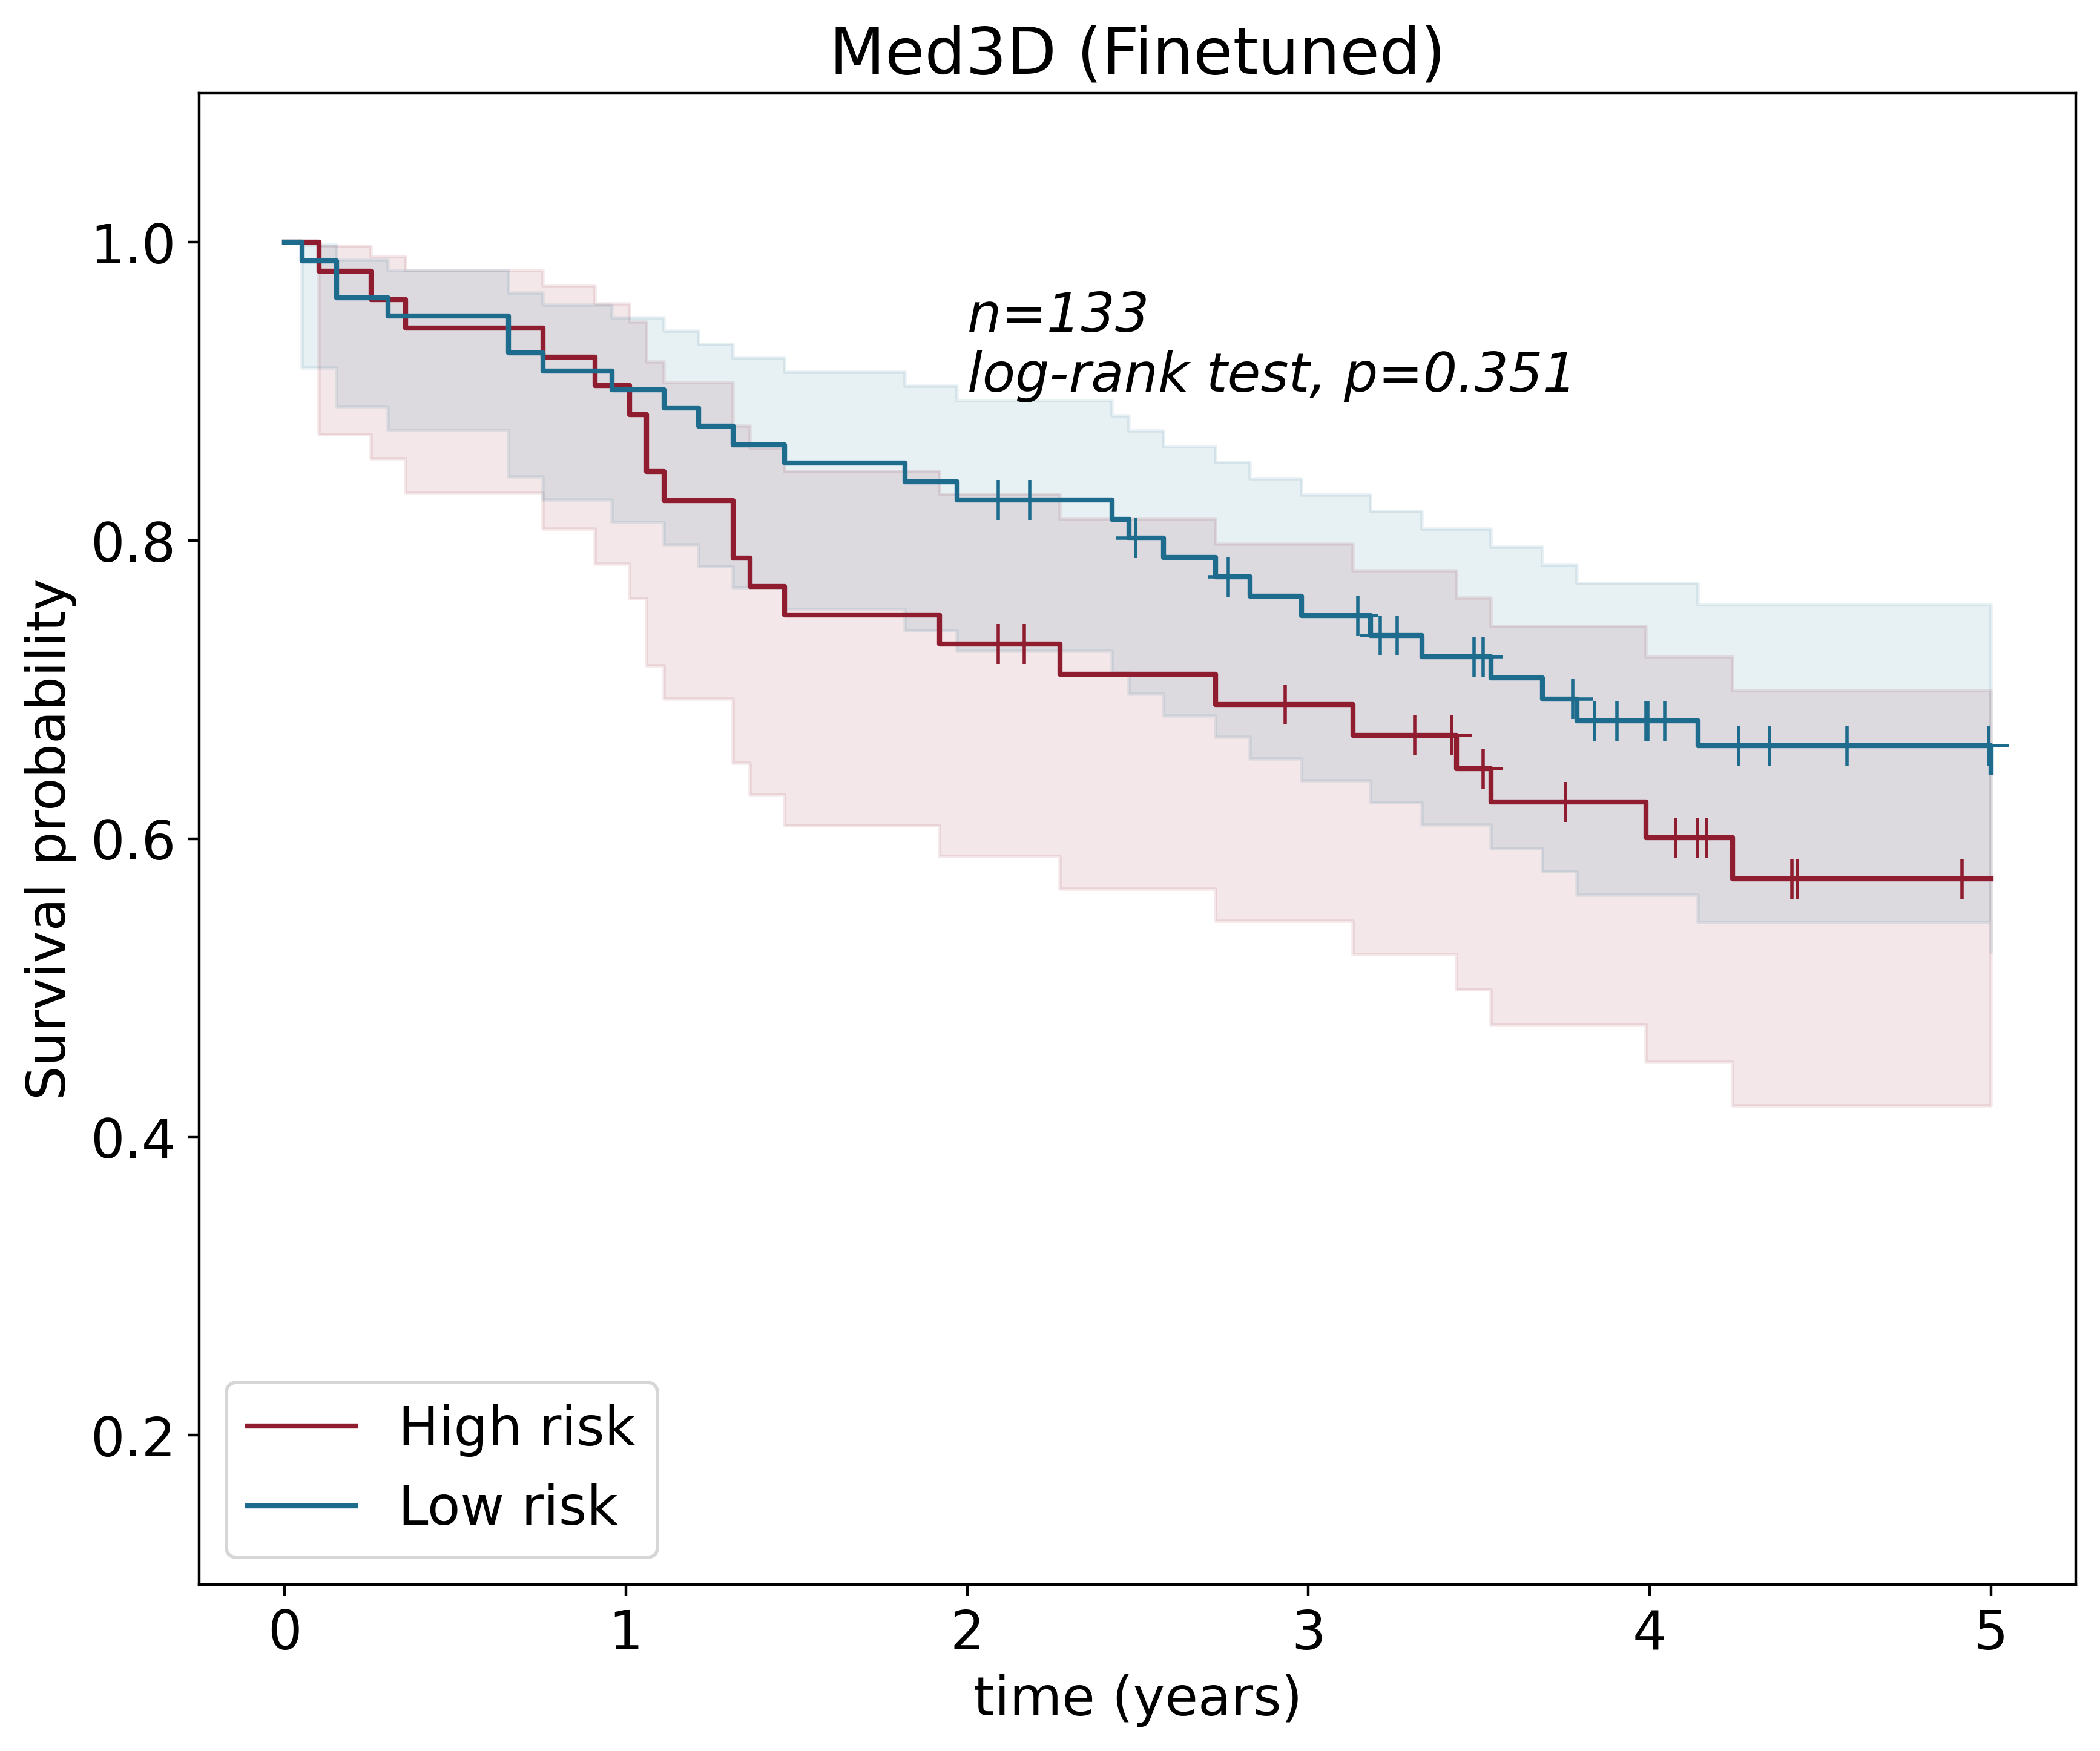

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -231.56
         time fit was run = 2024-01-18 01:32:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.26       1.30       0.28            -0.30             0.81                 0.74                 2.26

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 0.92 0.36       1.48
---
Concordance = 0.53
Partial AIC = 465.13
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.46

/tmp/ipykernel_2083549/1726220105.py:3: DtypeWarning:

Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.



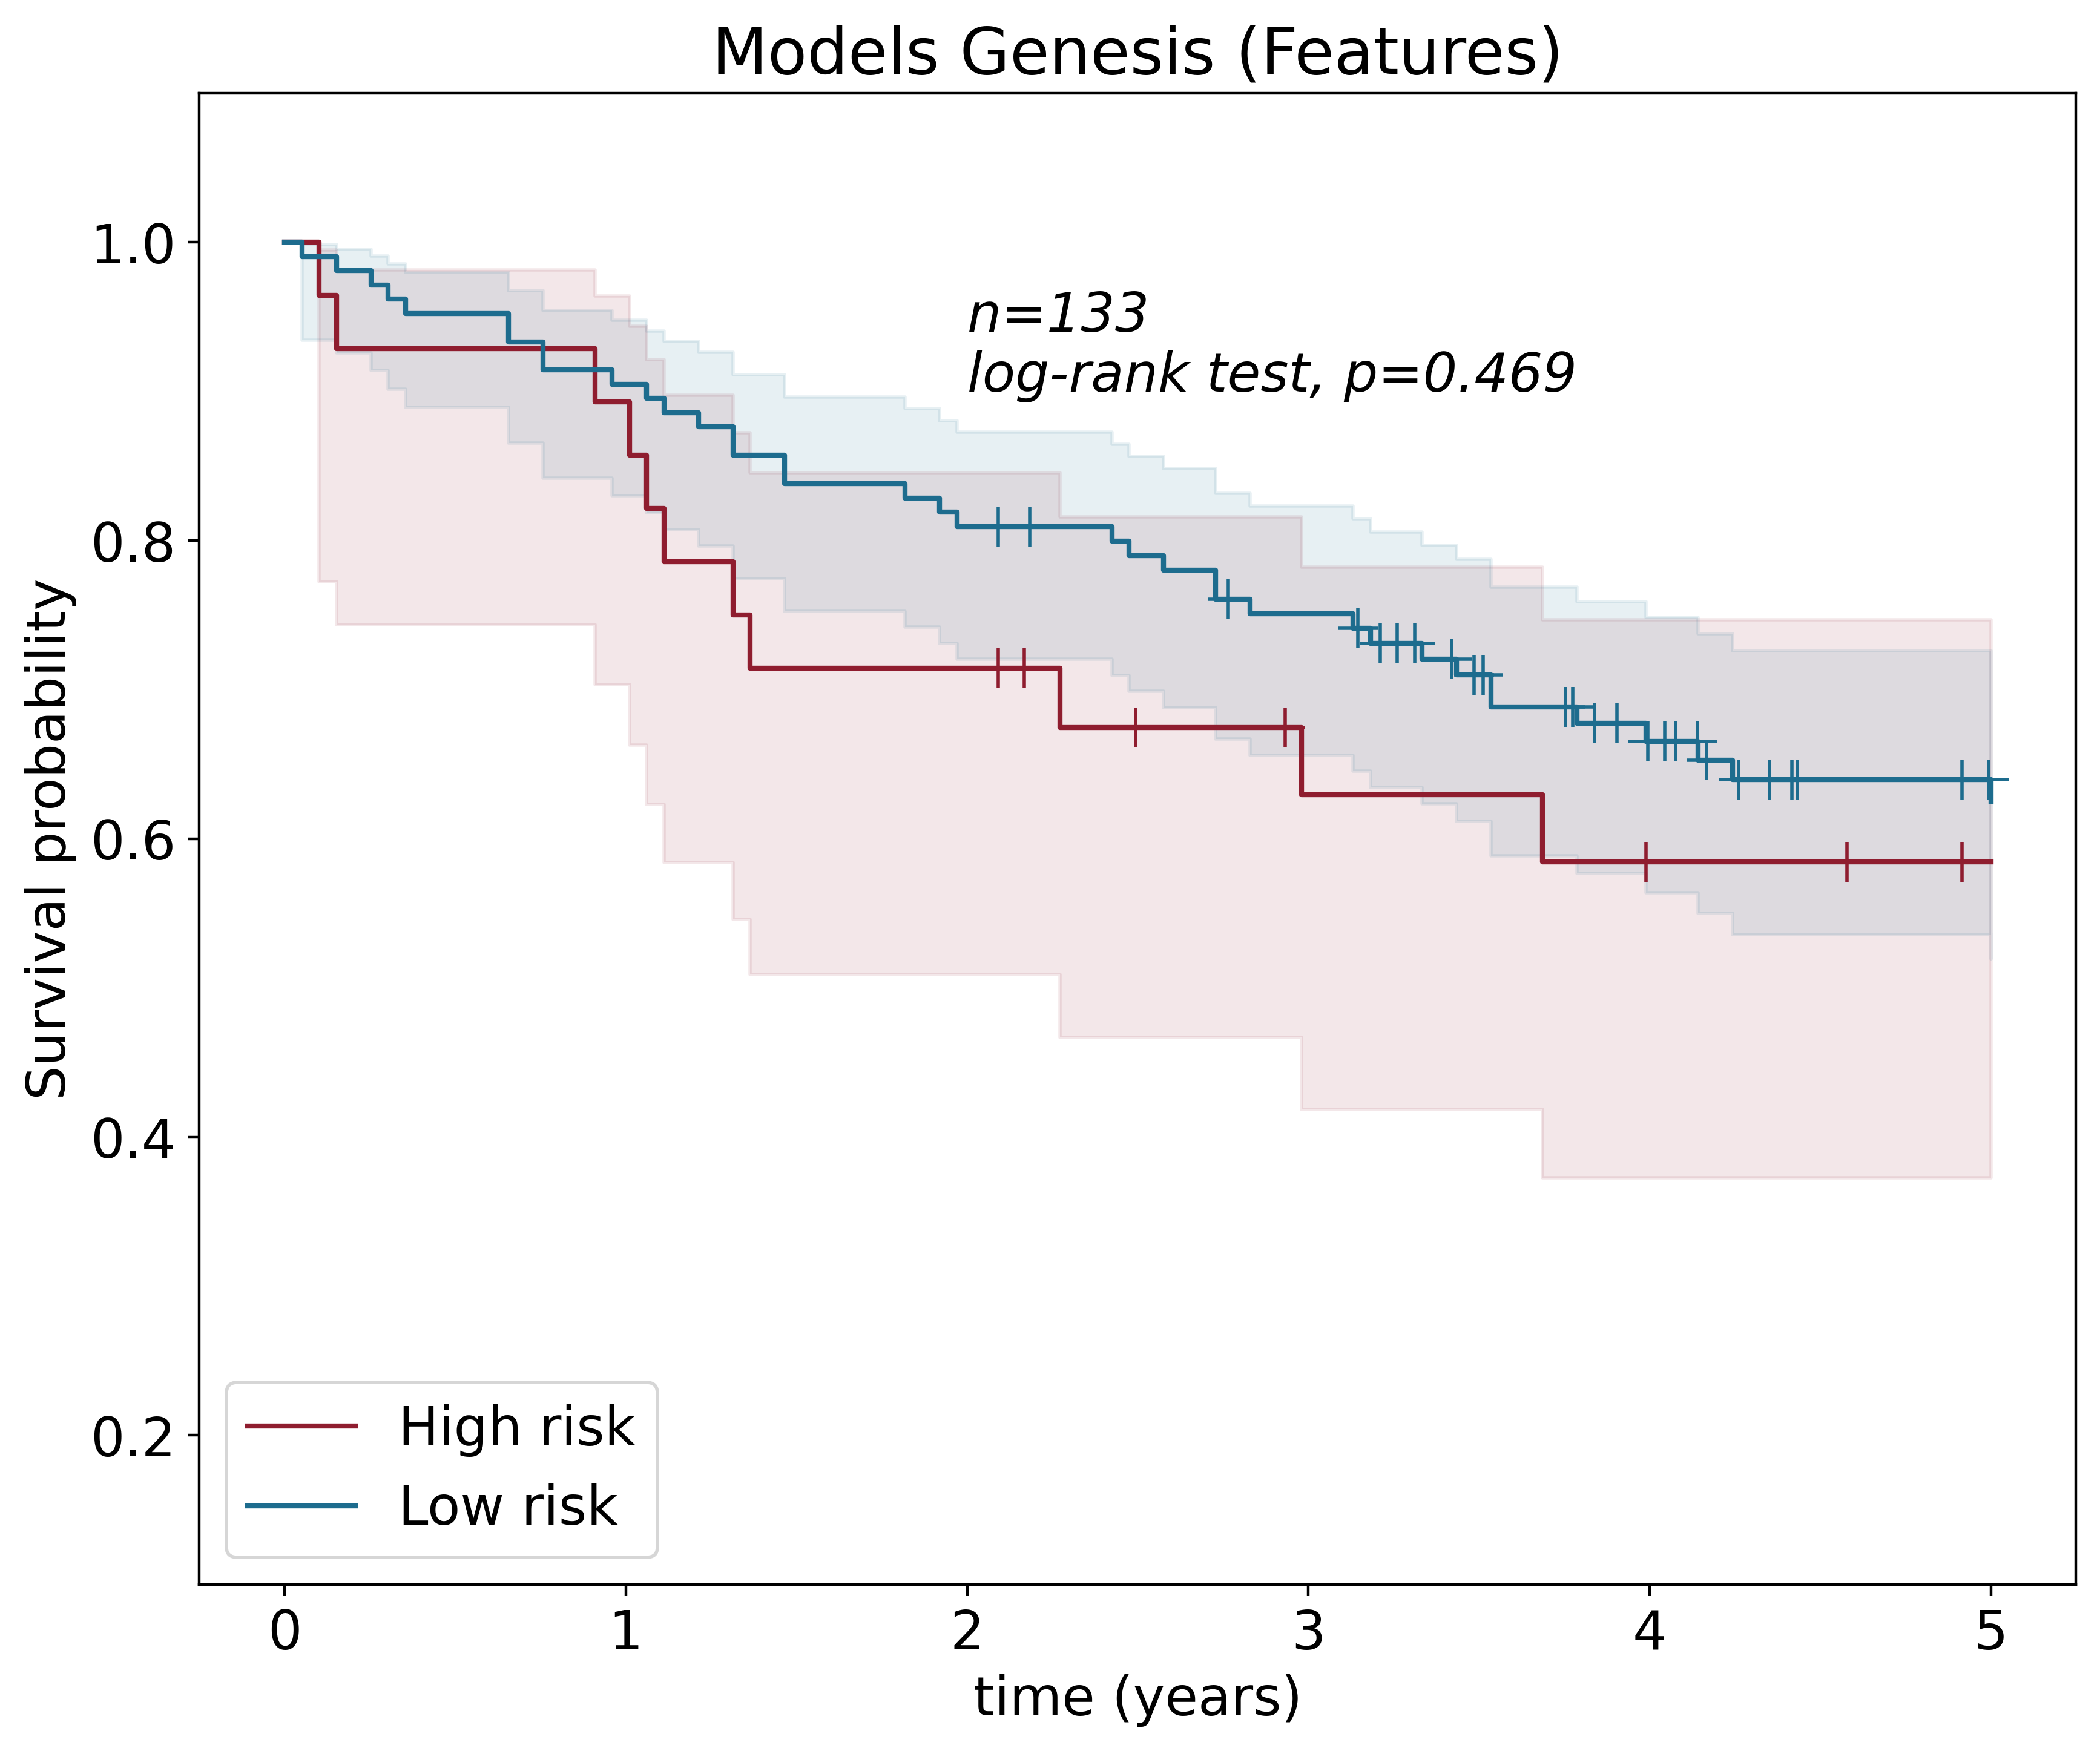

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -231.65
         time fit was run = 2024-01-18 01:32:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.27       1.32       0.33            -0.37             0.92                 0.69                 2.52

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 0.83 0.41       1.30
---
Concordance = 0.53
Partial AIC = 465.30
log-likelihood ratio test = 0.66 on 1 df
-log2(p) of ll-ratio test = 1.26

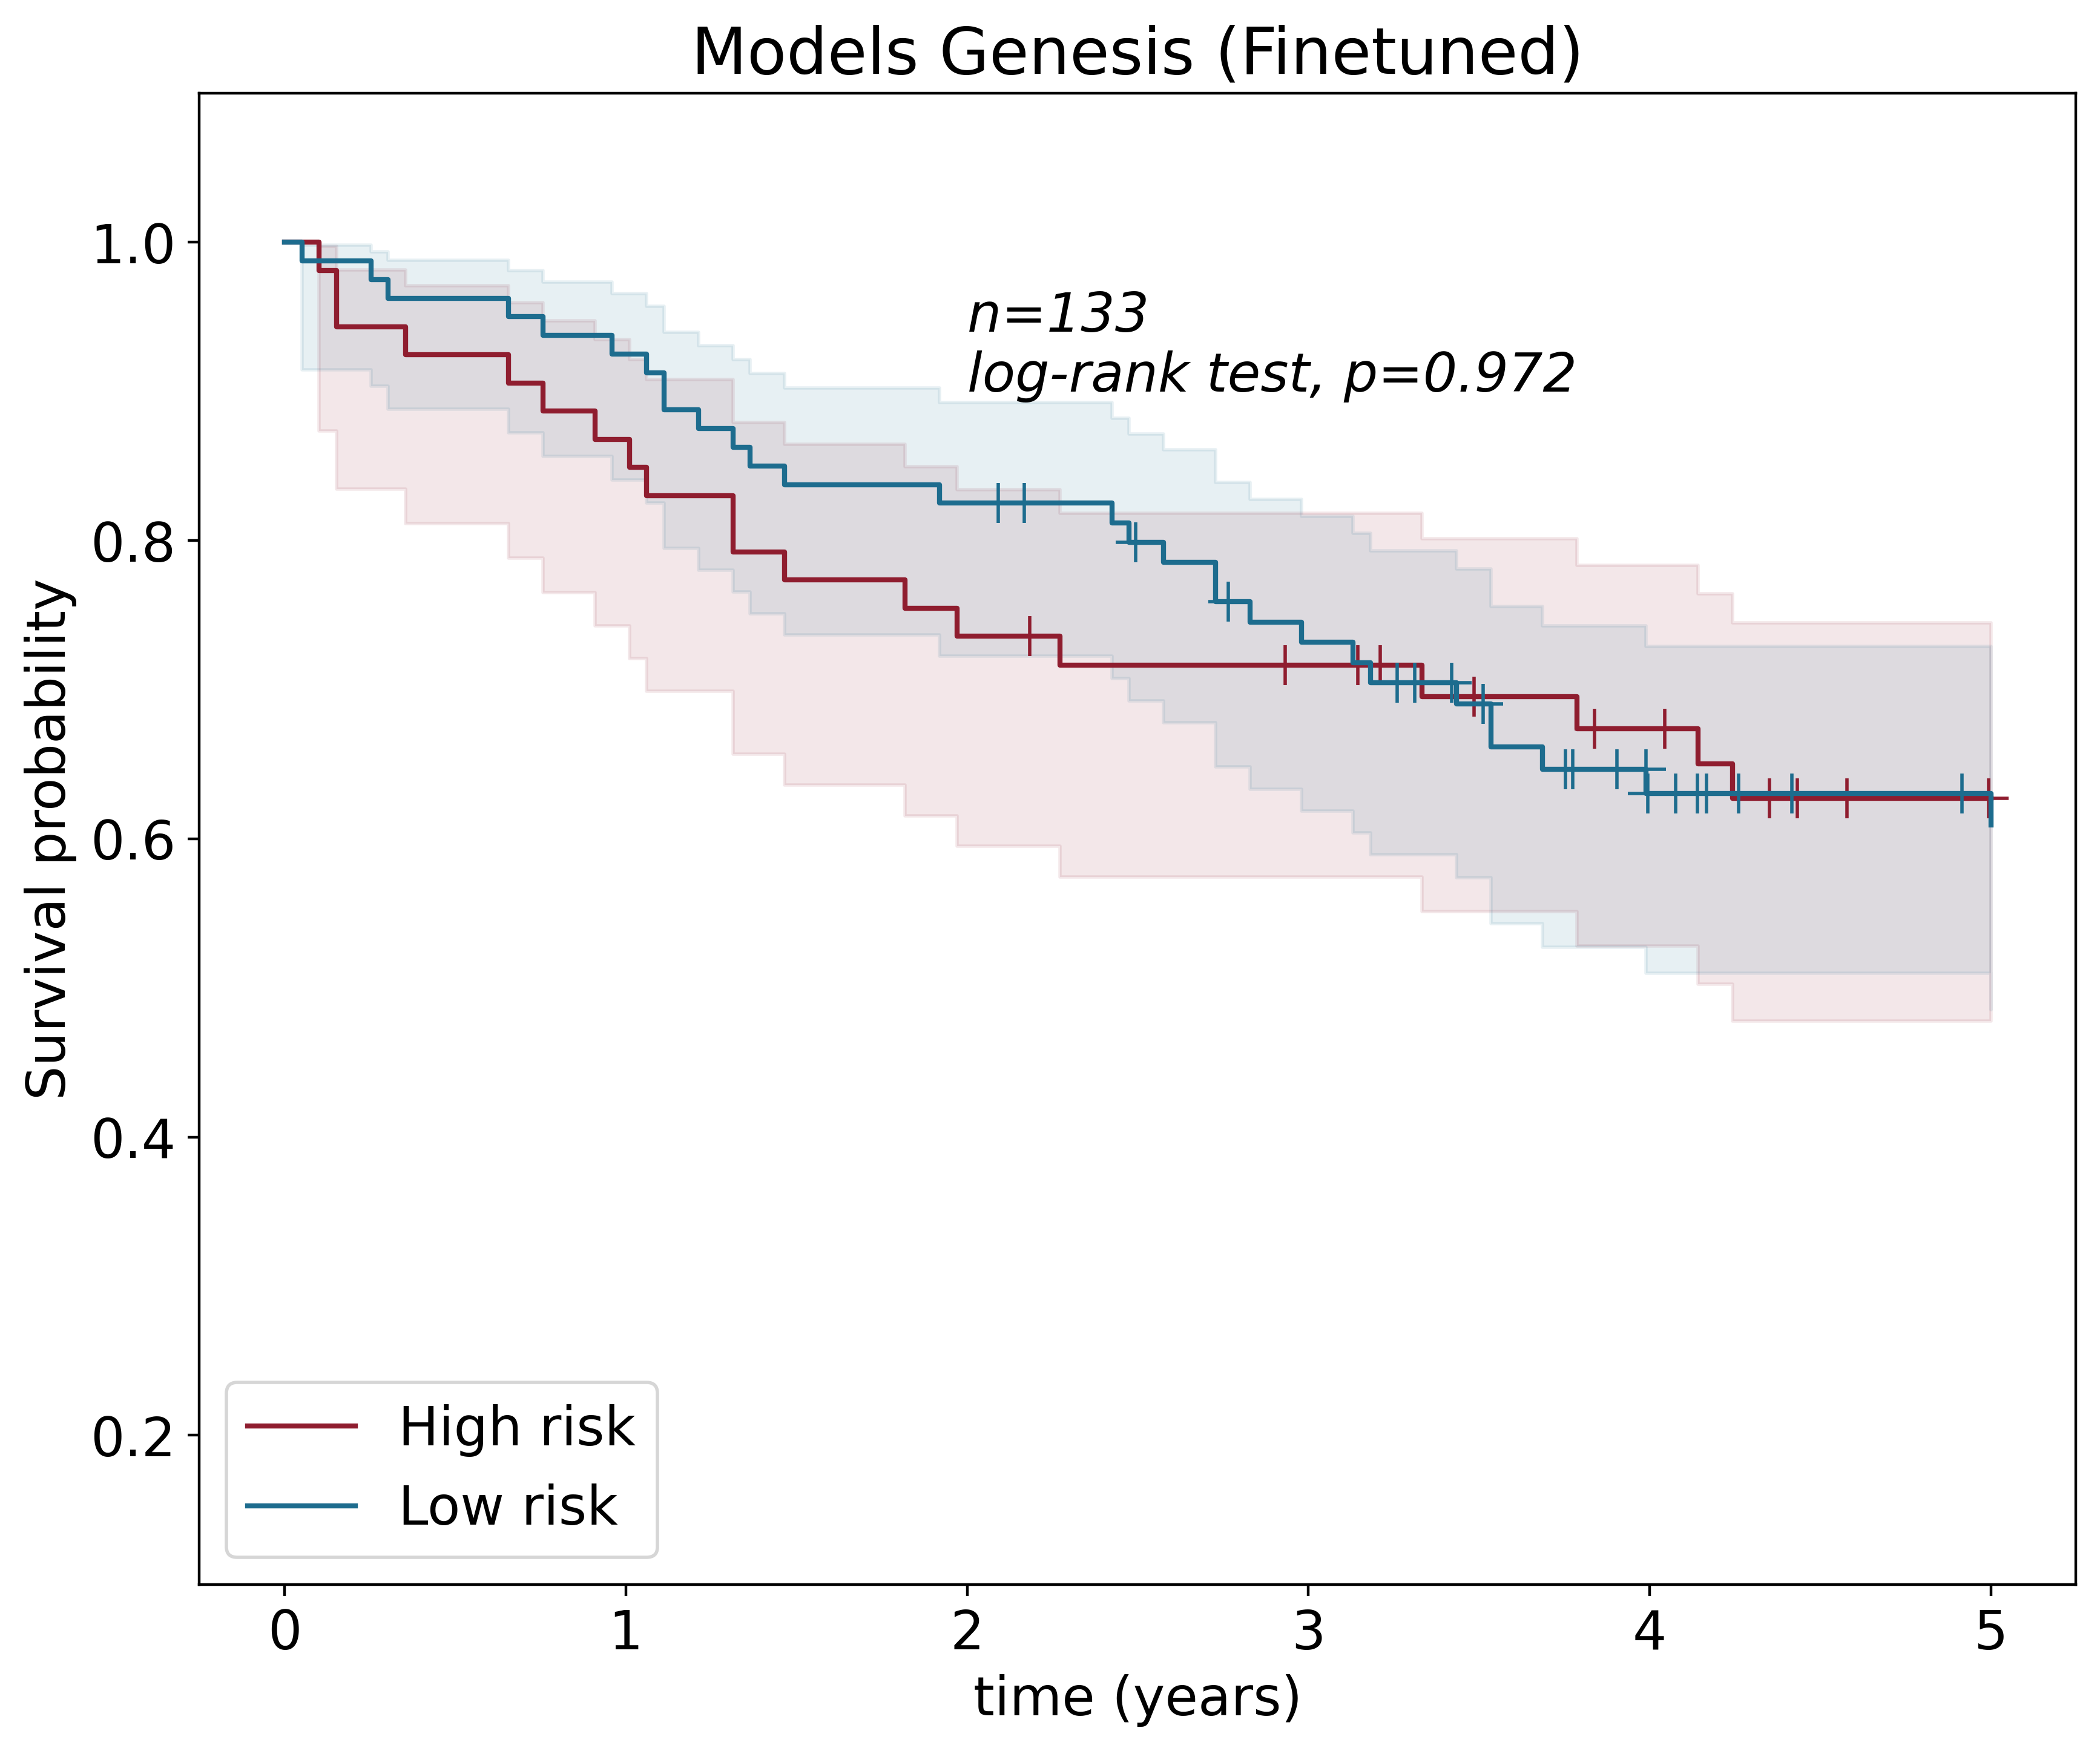

<lifelines.CoxPHFitter: fitted with 133 total observations, 82 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 133
number of events observed = 51
   partial log-likelihood = -231.95
         time fit was run = 2024-01-18 01:32:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
group       0.07       1.07       0.28            -0.49             0.63                 0.61                 1.88

            cmp to    z    p   -log2(p)
covariate                              
group         0.00 0.25 0.80       0.32
---
Concordance = 0.51
Partial AIC = 465.90
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.32

In [16]:
cox_results = {}
for model_implementation, path in radio_implementation_dict.items():
    df = pd.read_csv(path)
    df["surv2yr"] = (df["Survival.time"] / 365.0 >= 2).astype(int)
    df = df[~((df["surv2yr"] == 0) & (df["deadstatus.event"].astype(int) == 0))]
    median = median_dict[model_implementation]
    lung1_pred = df["conf_scores_class_1"].values if "conf_scores_class_1" in df.columns else df["conf_scores_class"].values
    df.loc[lung1_pred > median, "group"] = "Low risk"
    df.loc[lung1_pred <= median, "group"] = "High risk"
    plot_km_curve(df, title=model_implementation, save_path=f"figures_vector_pdf/task3_radio_{model_implementation}.pdf")
    df["group"] = (df["group"] == "High risk").astype(int)
    cox_results[model_implementation] = get_univariate_result(df)

In [17]:
cox_results_df = pd.DataFrame(cox_results).T

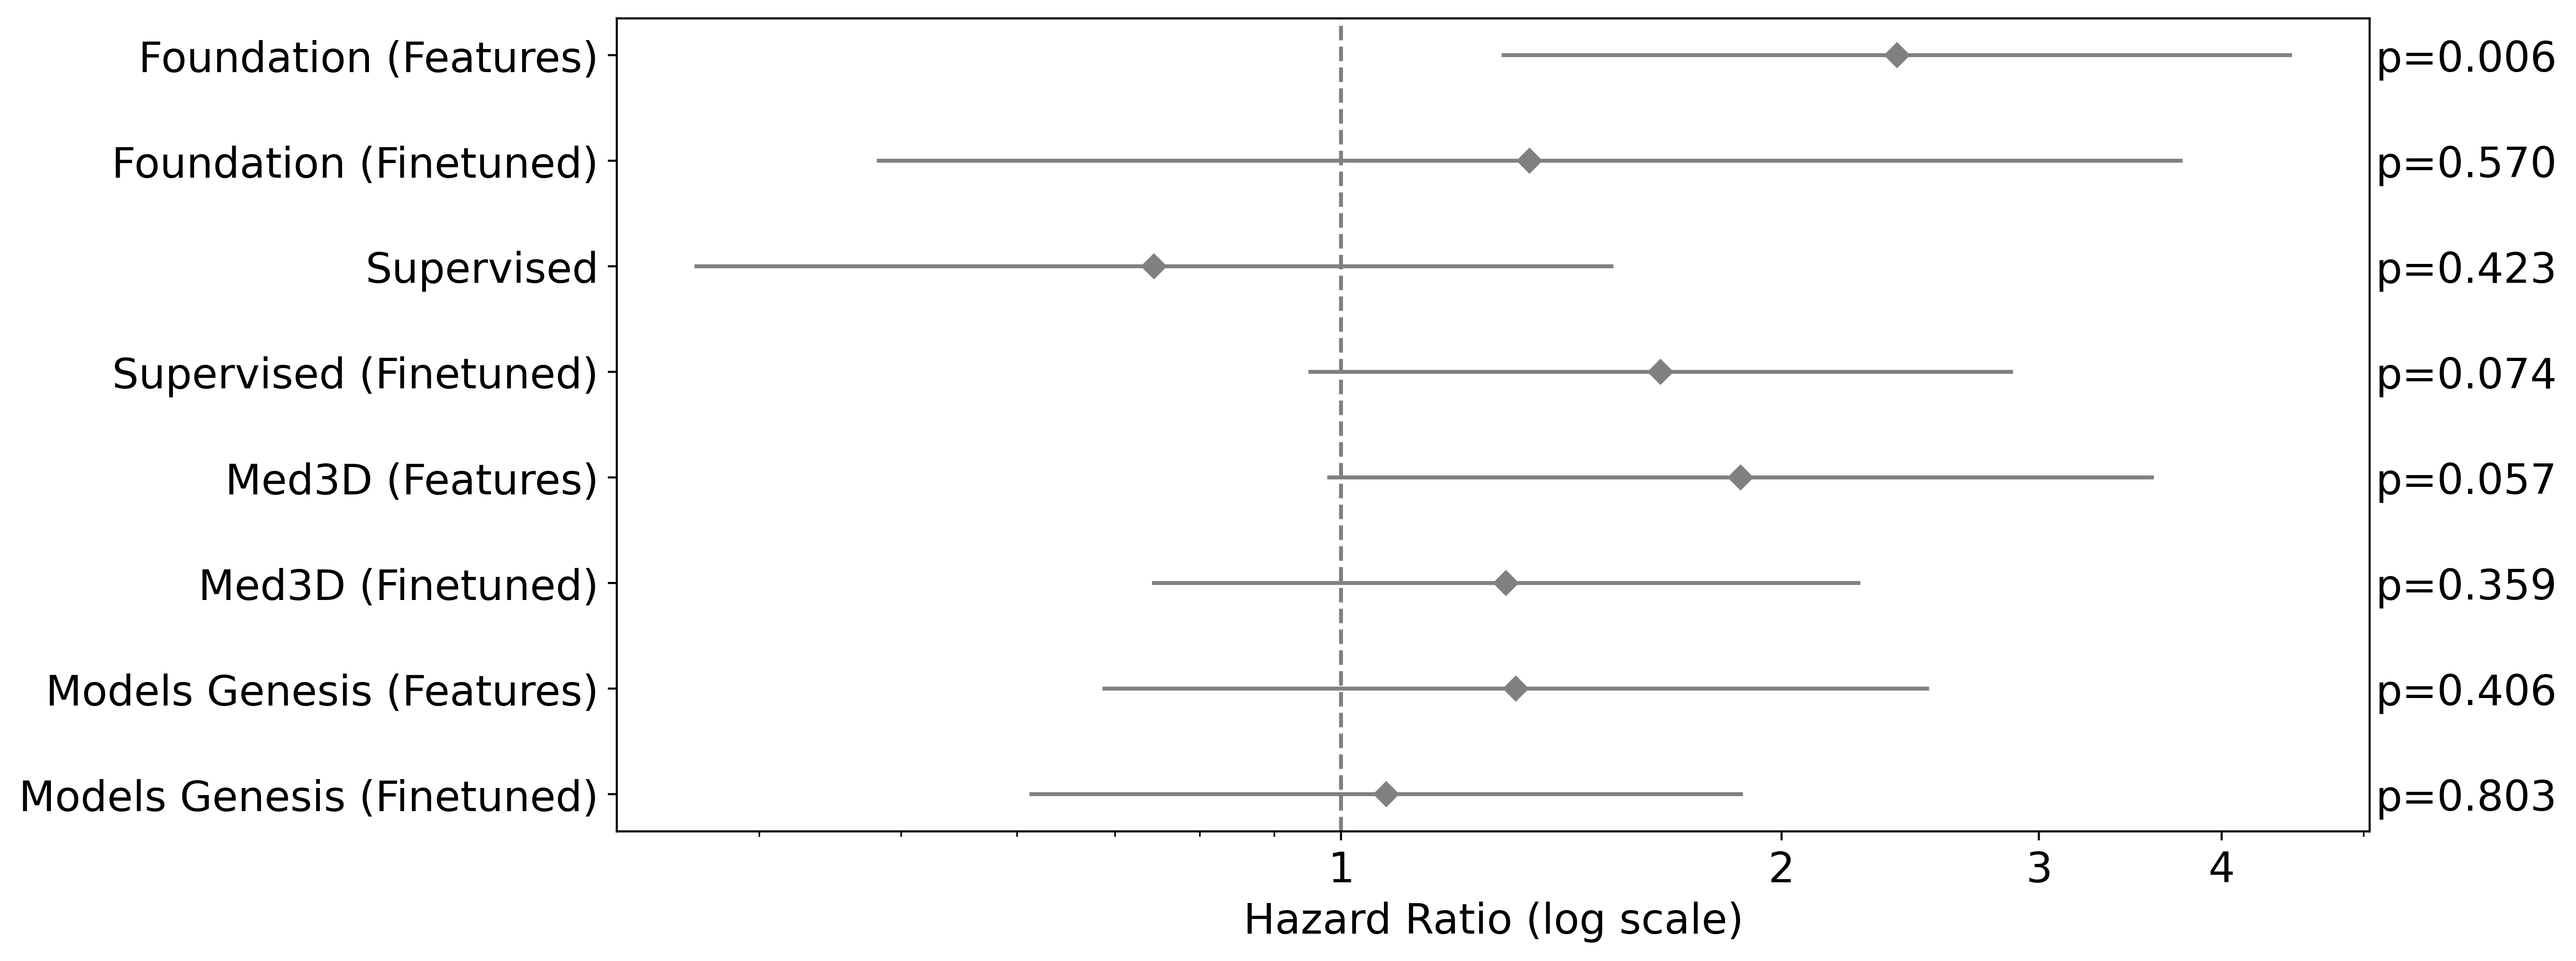

In [18]:
import matplotlib

fig, ax = plt.subplots(figsize=(12, len(cox_results_df) * 0.7))

# For each group, plot a point for HR and a line for the CI
for i, row in cox_results_df[::-1].iterrows():
    ax.plot([row["HR low CI"], row["HR high CI"]], [i, i], "gray")
    ax.plot(row["HR"], i, "D", color="gray")
    ax.text(5.1, i, f'p={row["p.value"]:.3f}', va="center_baseline")

ax.set_yticks(range(len(cox_results_df)))
ax.set_xscale("log")
ax.set_xlabel("Hazard Ratio (log scale)")
ax.set_xticks([1, 2, 3, 4])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axvline(1, color="grey", linestyle="--")

plt.savefig("figures_vector_pdf/task3_radio_cox.pdf", bbox_inches="tight", format="pdf")
plt.show()